In [1]:
import sys
sys.path.append("../")
import os
from datetime import date, datetime
import settings
import zipfile
import json
import matplotlib.pyplot as plt

from process_sentinel3 import OLCIdata, OLCIdataGenerator
import snappy_utils

In [2]:
processed_data_path = settings.processed_data_path
raw_data_path = settings.raw_data_path
DATA_PATH = settings.processed_data_path
DATE_FORMAT = '%Y-%m-%d'

In [3]:
START_DATE = '2019-12-21'
END_DATE = '2020-03-21'

#contorno interno lat/lon
INTERNAL_CONTOUR = [[-34.85044049, -55.05341557], [-34.85254593, -55.06282895], [-34.84523452, -55.07215948], 
                    [-34.84214073, -55.08336897], [-34.83733203, -55.08595825], [-34.830501, -55.07932854], 
                    [-34.82322889, -55.07377278], [-34.81443658, -55.06745663], [-34.80518264, -55.06063834], 
                   [-34.79828906, -55.05565486], [-34.79200075, -55.04700809], [-34.80233605, -55.04418996],
                   [-34.81042967, -55.04493995], [-34.82011843, -55.04664643], [-34.82953074, -55.04855582],
                   [-34.83996726, -55.0500401], [-34.85044049, -55.05341557]]
# lon/lat
INTERNAL_CONTOUR_2 = [[coord[1], coord[0]] for coord in INTERNAL_CONTOUR]

# longitude, latitude
CONTROL_COORDS_lonlat = [[-55.05218561, -34.79350339], [-55.04275225, -34.80644736], [-55.06375682, -34.82126589],
                 [-55.04579698, -34.78860639], [-55.04796407, -34.81608362], [-55.0601278, -34.80807322],
                 [-55.05417706, -34.83326008], [-55.07680277, -34.8314941], [-55.05205109, -34.84231436], 
                 [-55.08815247, -34.83684142], [-55.04217516, -34.79646286], [-55.0683368, -34.8412471],
                 [-55.06439235, -34.83036737], [-55.07488051, -34.81978377], [-55.05803691, -34.84653341], 
                 [-55.08188377, -34.84258836], [-55.06344332, -34.85348254]]
# latitude, longitude
CONTROL_COORDS = [[coord[1], coord[0]] for coord in CONTROL_COORDS_lonlat]

CYANO_GT_DAYS = ['2015-12-30', '2016-01-07', '2016-01-13', '2016-01-23',
           '2016-01-27', '2016-02-03', '2016-02-10', '2016-02-18',
           '2016-02-24', '2016-03-02', '2016-03-10', '2016-03-22',
           '2016-03-29', '2016-04-07', '2016-12-01', '2016-12-09',
           '2016-12-16', '2016-12-22', '2017-01-02', '2017-01-11',
           '2017-01-18', '2017-01-24', '2017-02-02', '2017-02-08',
           '2017-02-15', '2017-02-22', '2017-03-01', '2017-03-08',
           '2017-03-23', '2017-03-31', '2017-04-07', '2017-12-07',
           '2017-12-28', '2018-01-03', '2018-01-11', '2018-01-18',
           '2018-01-25', '2018-01-31', '2018-02-08', '2018-02-15',
           '2018-02-22', '2018-03-01', '2018-03-07', '2018-03-26',
           '2018-04-05', '2018-04-18', '2018-11-13', '2018-11-20',
           '2018-11-30', '2018-12-13', '2018-12-20', '2018-12-28',
           '2019-01-04', '2019-01-11', '2019-01-18', '2019-01-24',
           '2019-01-31', '2019-02-07', '2019-02-15', '2019-02-21',
           '2019-03-01', '2019-03-07', '2019-03-14', '2019-03-22',
           '2019-03-29', '2019-04-04', '2019-04-12', '2019-05-18',
           '2019-08-01', '2019-09-22', '2019-11-06', '2019-11-15',
           '2019-11-27', '2019-12-13', '2019-12-23', '2019-12-30',
           '2020-01-02', '2020-01-04', '2020-01-05', '2020-01-06',
           '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
           '2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
           '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
           '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22',
           '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
           '2020-01-27', '2020-01-29', '2020-01-30', '2020-01-31',
           '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04',
           '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08',
           '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
           '2020-02-14', '2020-02-15', '2020-02-17', '2020-02-18',
           '2020-02-19', '2020-02-24', '2020-02-25', '2020-02-27',
           '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04',
           '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
           '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
           '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-17',
           '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
           '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
           '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
           '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-03',
           '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
           '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
           '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
           '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
           '2020-04-20', '2020-04-21', '2020-04-23', '2020-04-24',
           '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29',
           '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03',
           '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
           '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11',
           '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15',
           '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19',
           '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-25',
           '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30',
           '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
           '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
           '2020-06-11', '2020-06-15', '2020-06-16', '2020-06-17',
           '2020-06-18', '2020-06-19', '2020-06-22', '2020-06-23',
           '2020-06-24', '2020-08-31', '2020-09-03', '2020-09-10',
           '2020-09-14', '2020-09-17', '2020-09-24', '2020-10-05',
           '2020-10-08', '2020-10-13', '2020-10-19', '2020-10-22',
           '2020-10-26', '2020-10-29', '2020-10-31', '2020-11-01',
           '2020-11-02', '2020-11-05', '2021-02-04']

## Create dictionary with paths for downloaded Sentinel-3 OLCI products

### Create from custom list of dates

In [ ]:
dates_list = CYANO_GT_DAYS

downloaded_OLCI_paths = {}
for d in dates_list:
    downloaded_OLCI_paths[d] = []
    try:
        raw_data_dirs = [os.path.join(raw_data_path, d, s) for s in os.listdir(os.path.join(raw_data_path, d))]
    except FileNotFoundError:
        print(f"FileNotFoundError error in {d}")
        continue
    
    for f in raw_data_dirs:
        if "S3" in f and "OL" in f:
            downloaded_OLCI_paths[d].append(f)
        
dates_list = [datetime.strptime(d, "%Y-%m-%d").date() for d in dates_list]

### Create from every downloaded product in raw data directory

In [3]:
downloaded_OLCI_paths = {}

raw_data_directories = os.listdir(raw_data_path)
raw_data_directories.sort()
for date_directory in raw_data_directories:
    downloaded_OLCI_paths[date_directory] = []
    for f in os.listdir(os.path.join(raw_data_path, date_directory)):
        if "S3" in f and "OL" in f:
            downloaded_OLCI_paths[date_directory].append(os.path.join(raw_data_path, date_directory, f))

## Process all products from dictionary to make subsets

In [5]:
python_exec_path = sys.executable
olci_processing_script_dir = "/home/enzo/Cyano_Detection/src/"
olci_processing_script_path = os.path.join(olci_processing_script_dir, "OLCI_processing.py")

print(f"{len(list(downloaded_OLCI_paths.keys()))} days to process")
for d, paths in downloaded_OLCI_paths.items():
    if len(paths) == 0:
        continue
    for i, p in enumerate(paths):
        input_data_path = p
        output_data_path = os.path.join(processed_data_path, d, "OLCI", f"subselection_{i}")
        
        run_command = f"cd {olci_processing_script_dir} ; {python_exec_path} {olci_processing_script_path} -i {input_data_path} -o {output_data_path}"
        print(os.popen(run_command).read())

808 days to process

100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-11-01/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-11-01/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-11-01/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-11-01/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-11-02/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-11-02/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-11-04/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-11-04/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-11-04/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_D


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-12-05/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-12-05/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-12-06/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-12-06/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-12-07/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-12-07/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-12-08/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2018-12-08/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2018-12-09/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-01-09/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-01-09/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-01-10/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-01-10/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-01-11/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-01-11/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-01-12/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-01-12/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-01-13/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-02-12/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-02-12/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-02-13/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-02-13/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-02-14/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-02-14/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-02-15/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-02-15/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-02-16/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-03-18/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-03-18/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-03-19/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-03-19/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-03-19/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-03-19/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-03-20/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-03-20/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-03-21/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-04-20/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-04-20/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-04-21/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-04-21/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-04-22/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-04-22/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-04-23/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-04-23/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-04-23/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-11-21/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-11-21/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-11-21/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-11-21/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-11-22/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-11-22/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-11-23/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-11-23/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-11-24/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-12-24/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-12-24/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-12-25/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-12-25/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-12-26/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-12-26/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-12-27/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2019-12-27/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2019-12-28/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-01-28/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-01-28/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-01-29/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-01-29/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-01-29/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-01-29/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-01-30/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-01-30/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-01-31/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-03-01/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-03-01/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-03-02/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-03-02/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-03-03/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-03-03/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-03-04/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-03-04/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-03-04/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-04-04/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-04-04/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-04-04/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-04-04/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-04-05/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-04-05/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-04-06/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-04-06/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-04-07/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-05-07/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-05-07/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-05-08/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-05-08/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-05-09/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-05-09/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-05-10/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-05-10/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-05-11/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-06-23/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-06-23/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-06-24/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-06-24/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-06-24/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-06-24/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-08-31/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-08-31/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-09-03/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-11-19/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-11-19/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-11-20/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-11-20/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-11-21/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-11-21/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-11-21/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-11-21/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-11-22/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-12-22/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-12-22/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-12-23/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-12-23/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-12-24/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-12-24/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-12-25/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2020-12-25/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2020-12-26/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-01-25/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-01-25/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-01-26/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-01-26/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-01-26/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-01-26/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-01-27/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-01-27/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-01-28/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-02-27/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-02-27/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-02-28/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-02-28/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-03-01/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-03-01/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-03-02/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-03-02/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-03-03/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-04-05/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-04-05/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-04-05/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-04-05/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-04-06/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-04-06/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-04-07/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-04-07/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-04-08/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-11-08/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-11-08/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-11-09/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-11-09/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-11-10/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-11-10/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-11-11/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-11-11/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-11-11/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-12-12/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-12-12/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-12-12/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-12-12/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-12-13/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-12-13/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-12-14/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2021-12-14/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2021-12-15/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-01-14/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-01-14/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-01-15/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-01-15/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-01-16/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-01-16/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-01-16/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-01-16/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-01-17/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-02-17/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-02-17/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-02-18/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-02-18/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-02-19/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-02-19/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-02-20/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-02-20/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-02-21/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-03-23/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-03-23/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-03-24/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-03-24/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-03-25/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-03-25/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-03-26/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-03-26/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-03-26/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-04-26/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-04-26/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-04-26/OLCI/subselection_1.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-04-26/OLCI/subselection_1.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-04-27/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-04-27/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-04-28/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/processed/2022-04-28/OLCI/subselection_0.tif


100% done.
Writing BEAM-DIMAP to /home/enzo/Cyano_Detection/data/processed/2022-04-29/OLCI/subselection_0.dim
Writing GeoTiff to /home/enzo/Cyano_Detection/data/proces

## Tag image cloudiness

levels of cloud:

0) Clear

1) minimum clouds over the lake

2) medium amount of clouds

3) too cloudy to be any good

In [ ]:
from IPython.display import clear_output
import time

data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, start_date='2018-11-01', end_date='2022-05-01', 
                                   tagging=True)
retag = False

for day in data_generator:
    print(day.date)
    print(day.metadata)
    current_metadata = day.metadata
    if current_metadata != {} and not retag:
        time.sleep(0.1)
        clear_output(wait=True)
        continue
    # display rgb of day
    fig = plt.figure(figsize=(20,10))
    plt.imshow(day.rgb)
    plt.show()
    # get user input
    user_input = input()
    # overwrite with changes
    with open(day.metadata_path, 'w') as fp:
        current_metadata["cloud level"] = user_input
        json.dump(current_metadata, fp)
    clear_output(wait=True)

###  Generate images from every clear day

/home/ubuntu/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


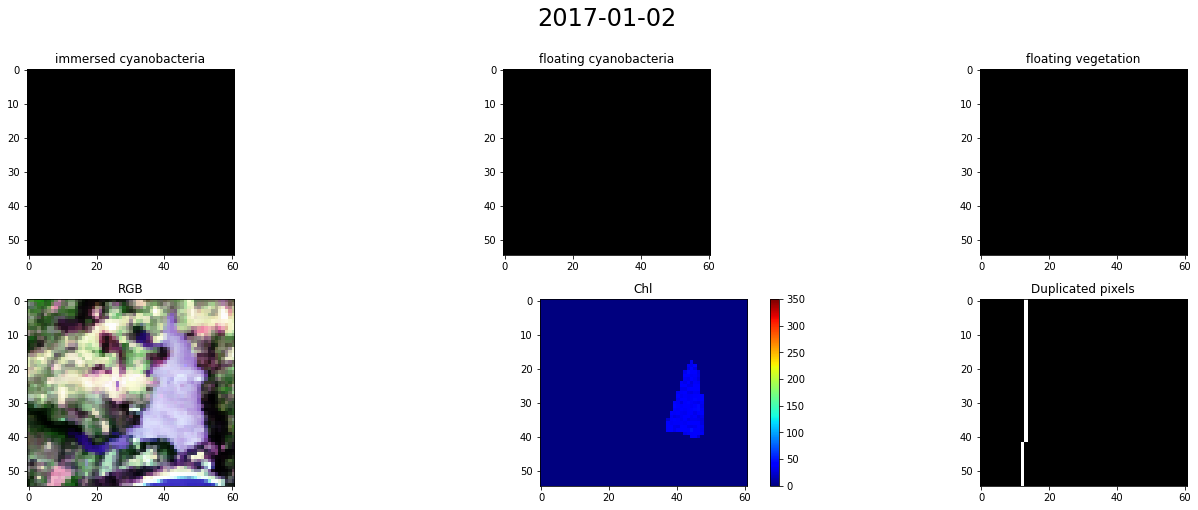

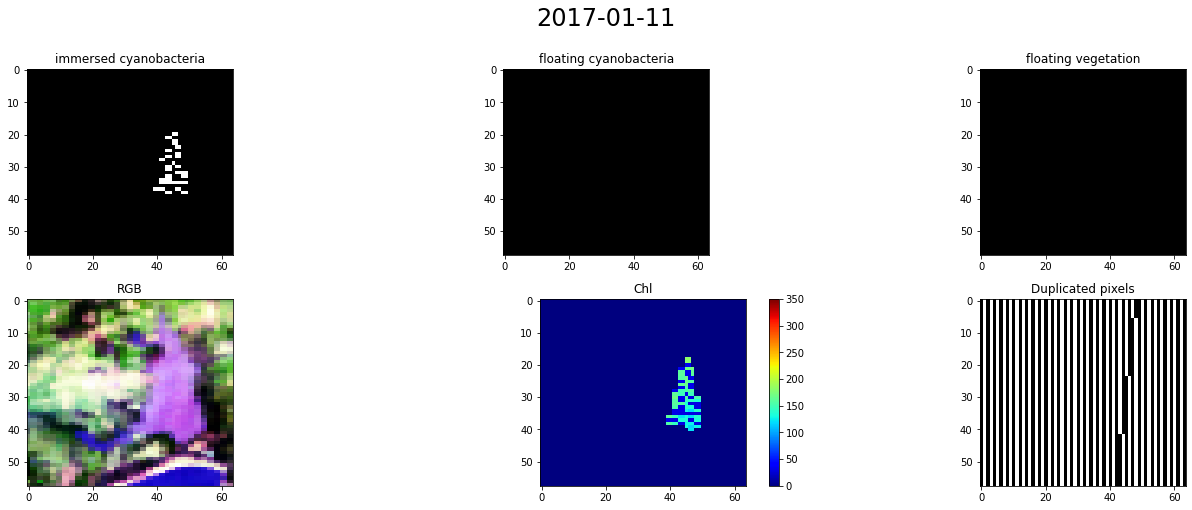

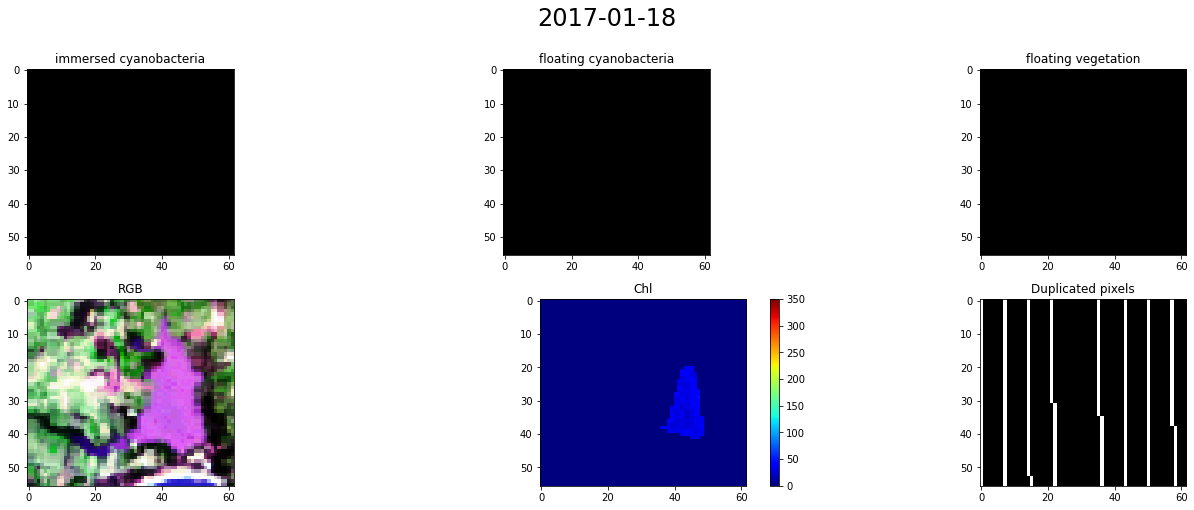

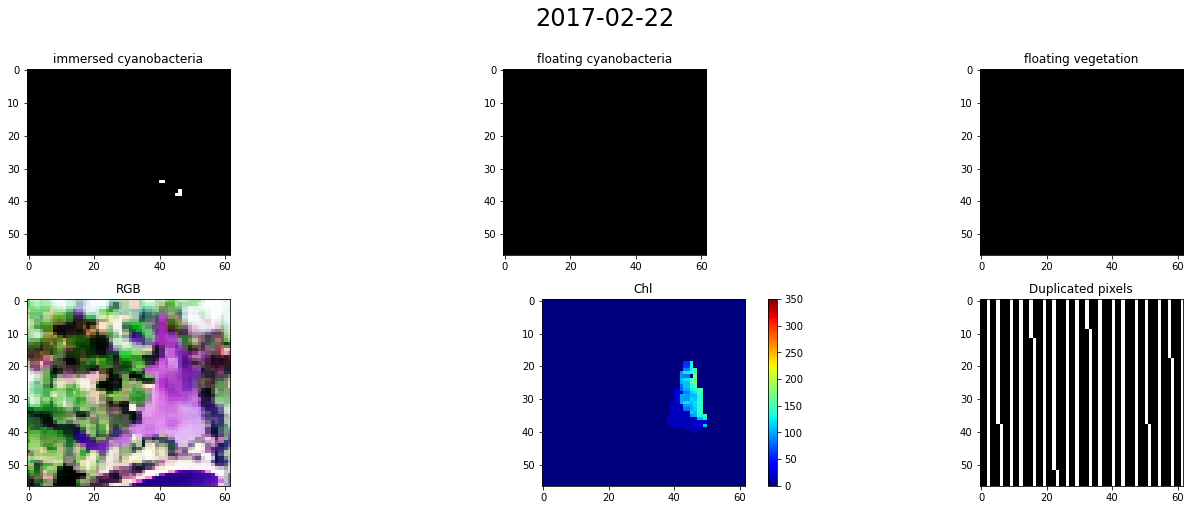

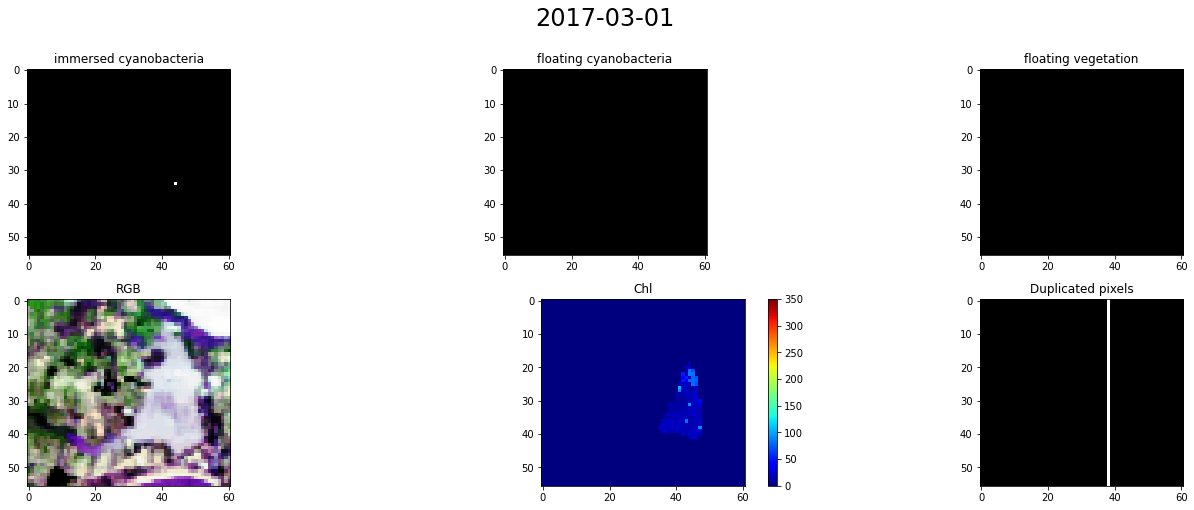

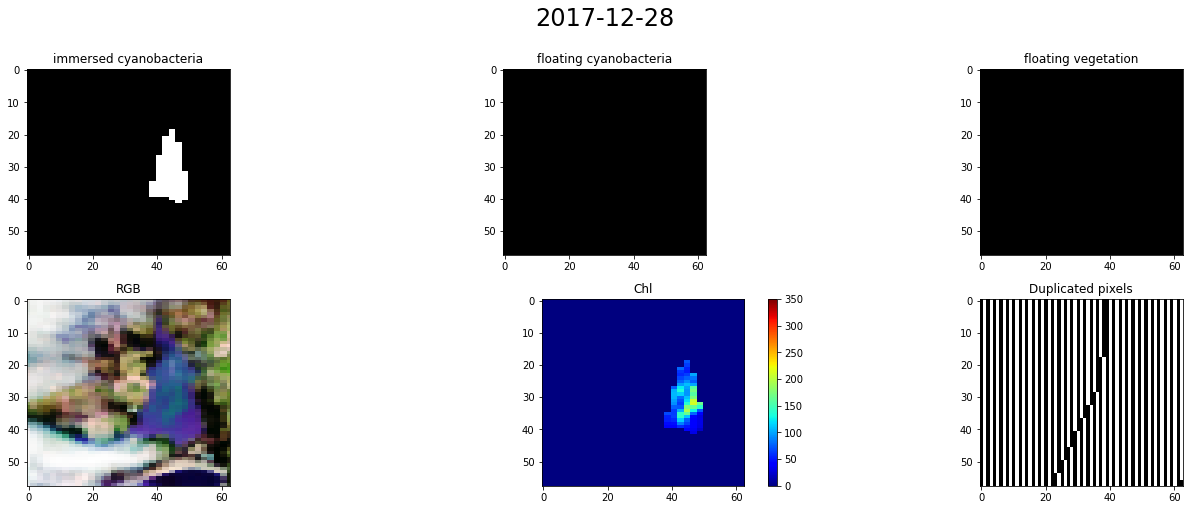

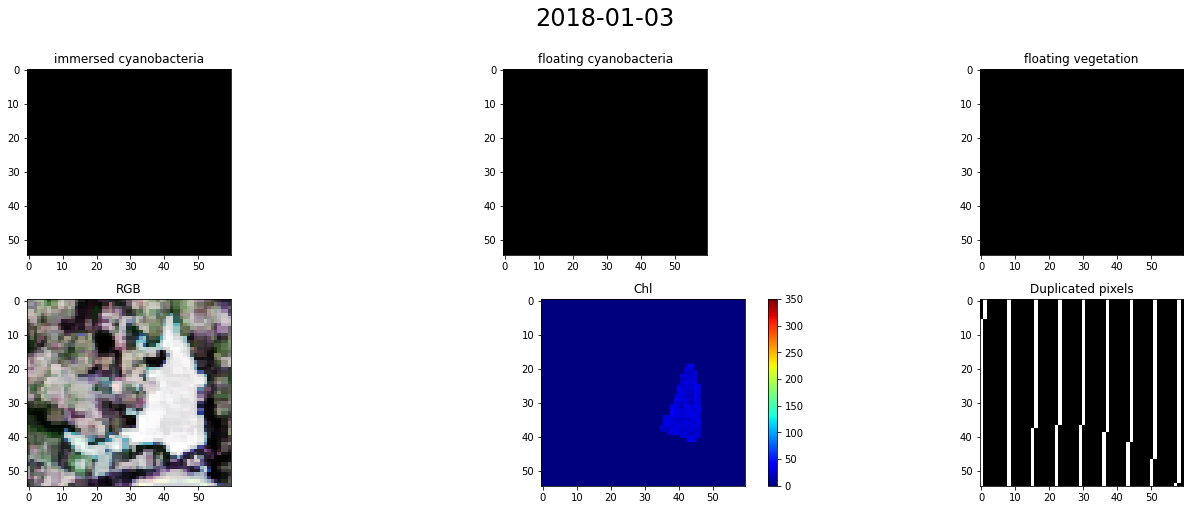

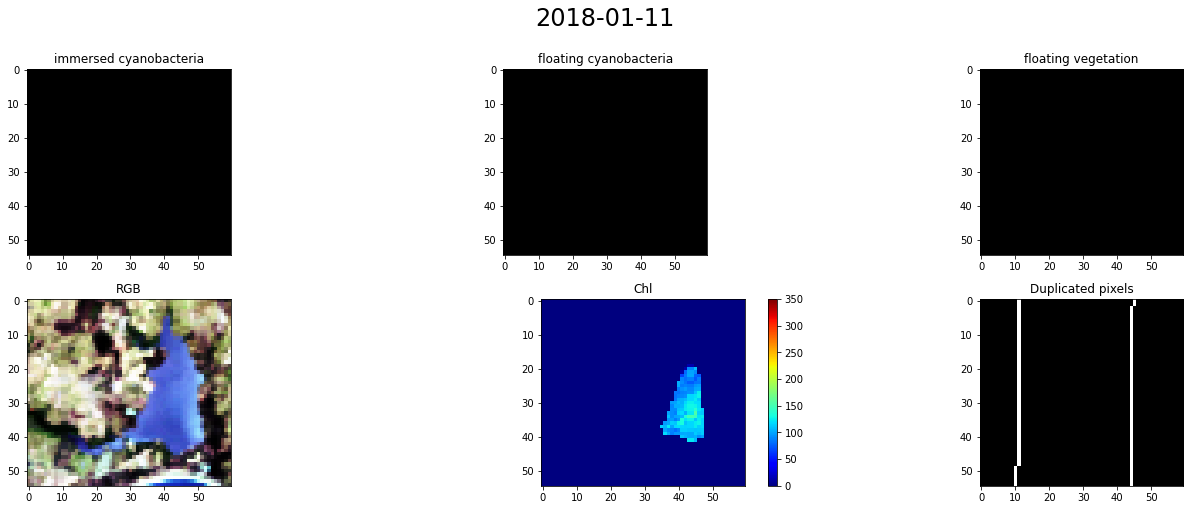

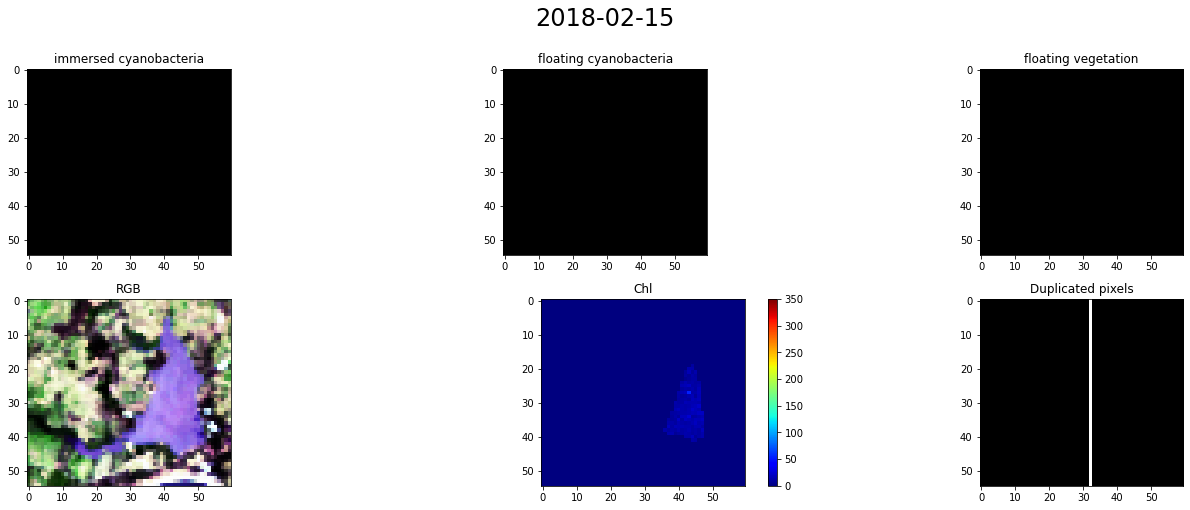

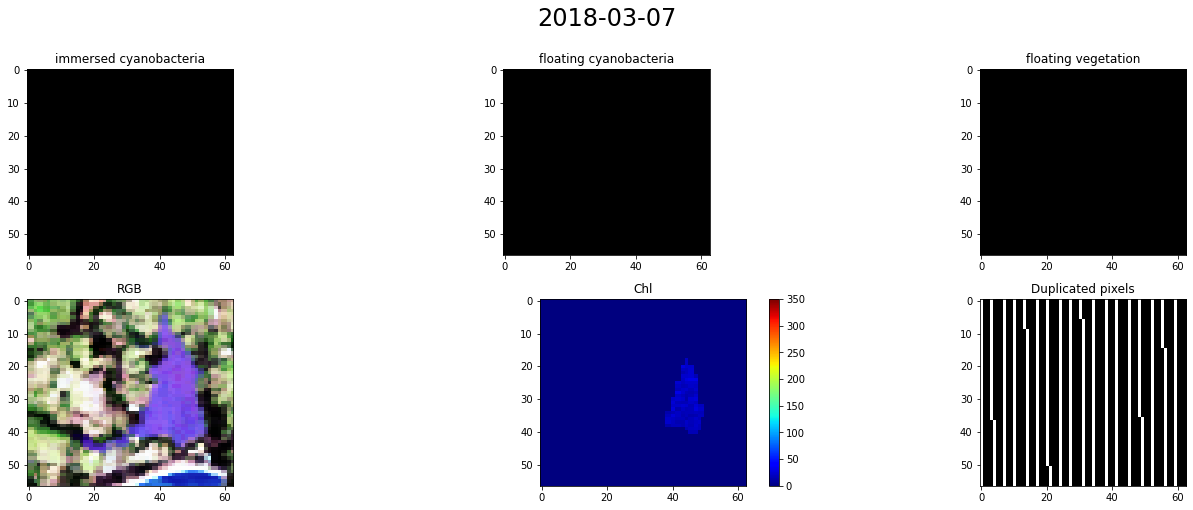

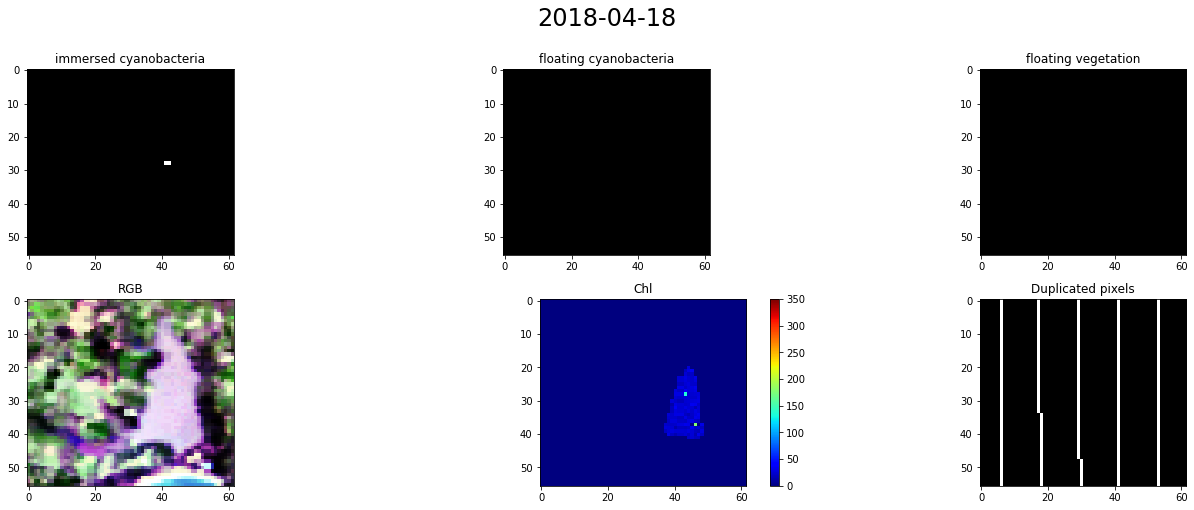

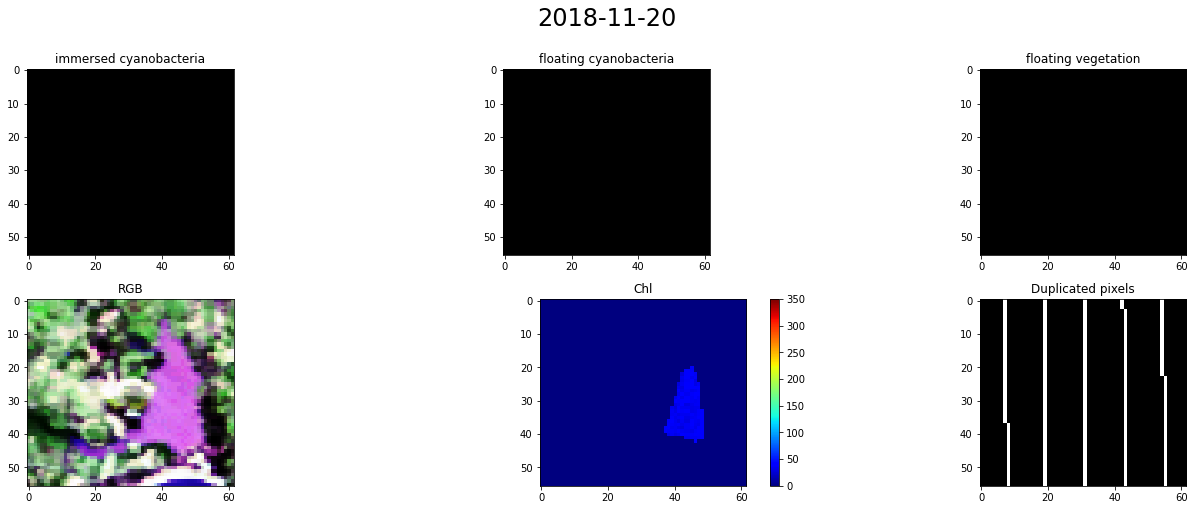

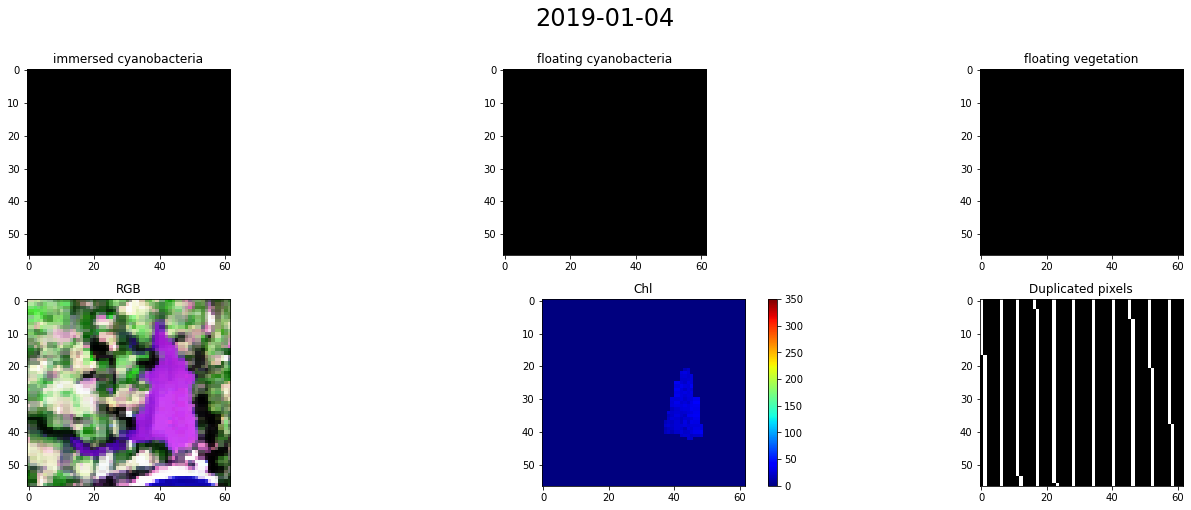

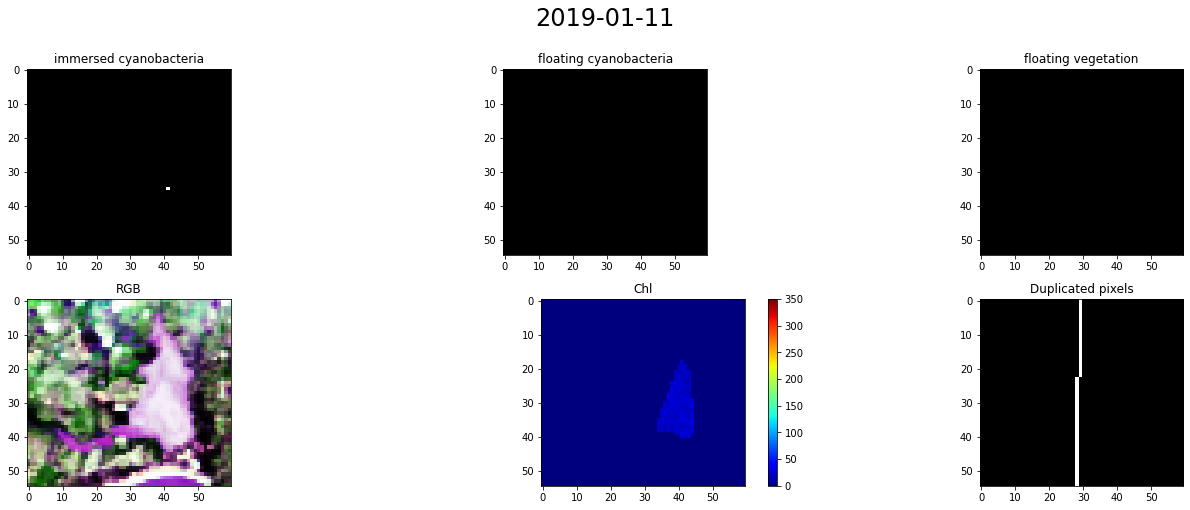

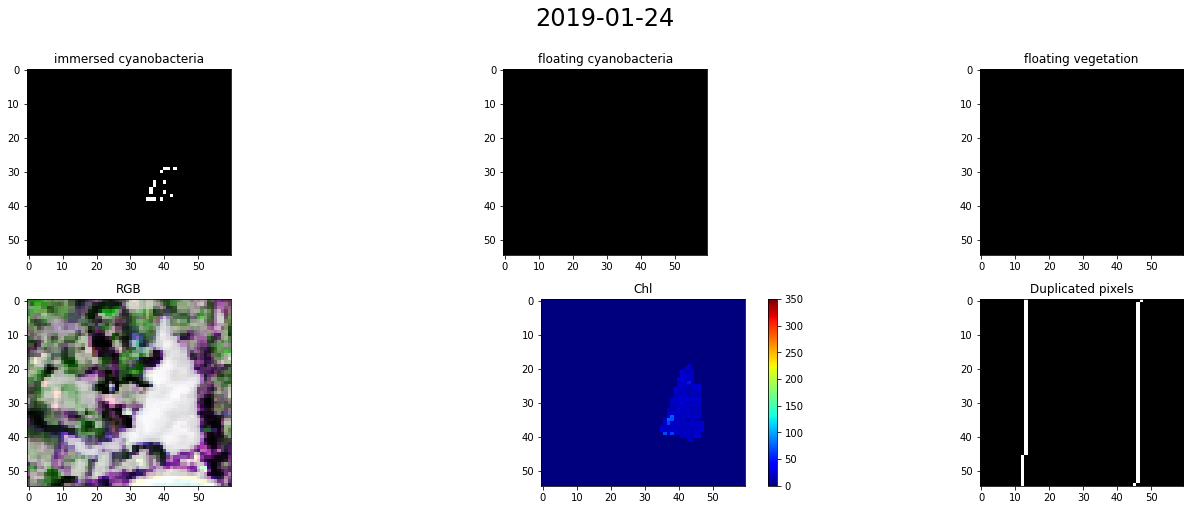

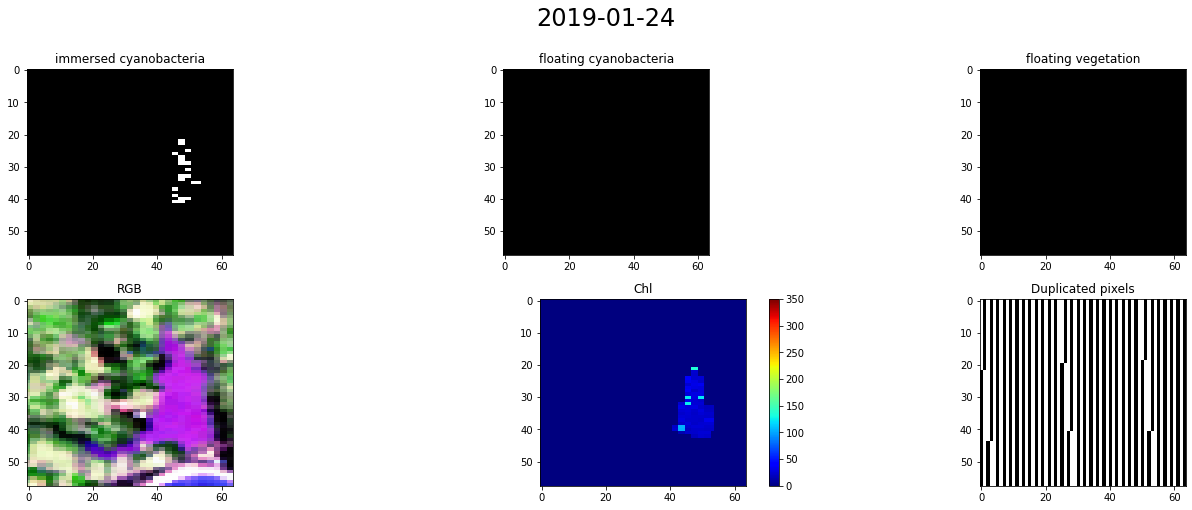

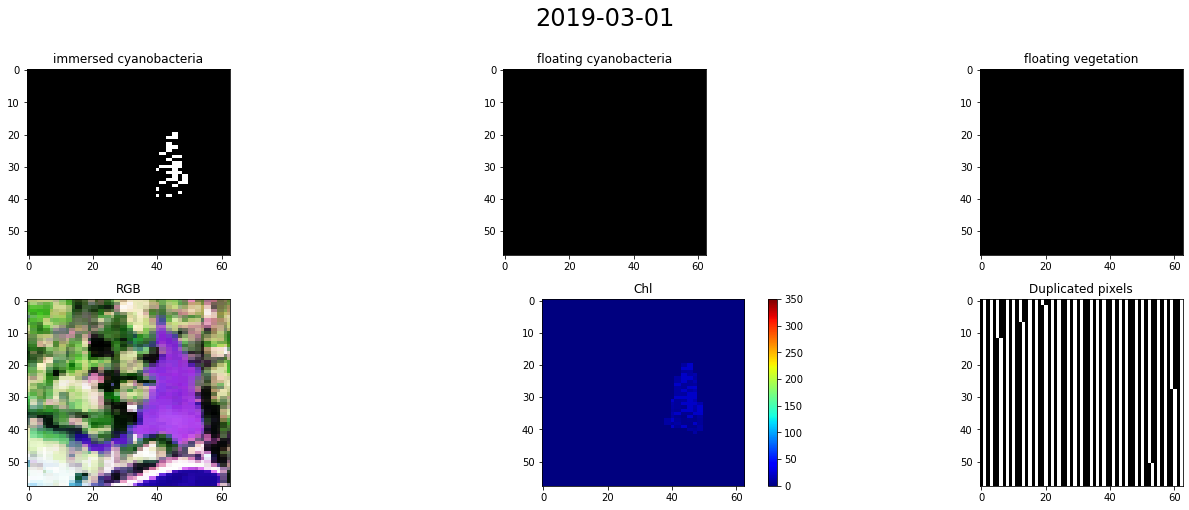

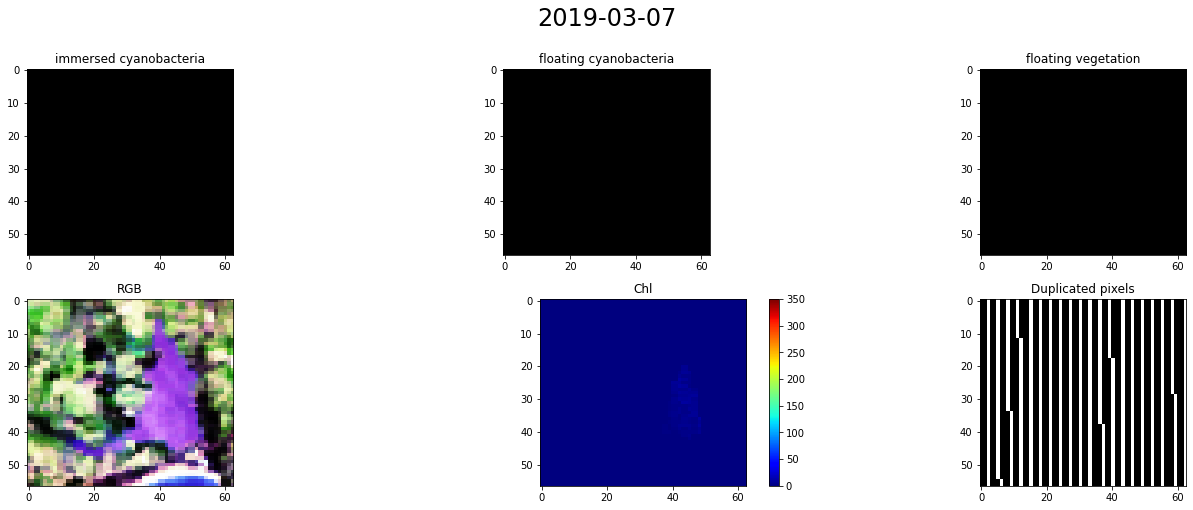

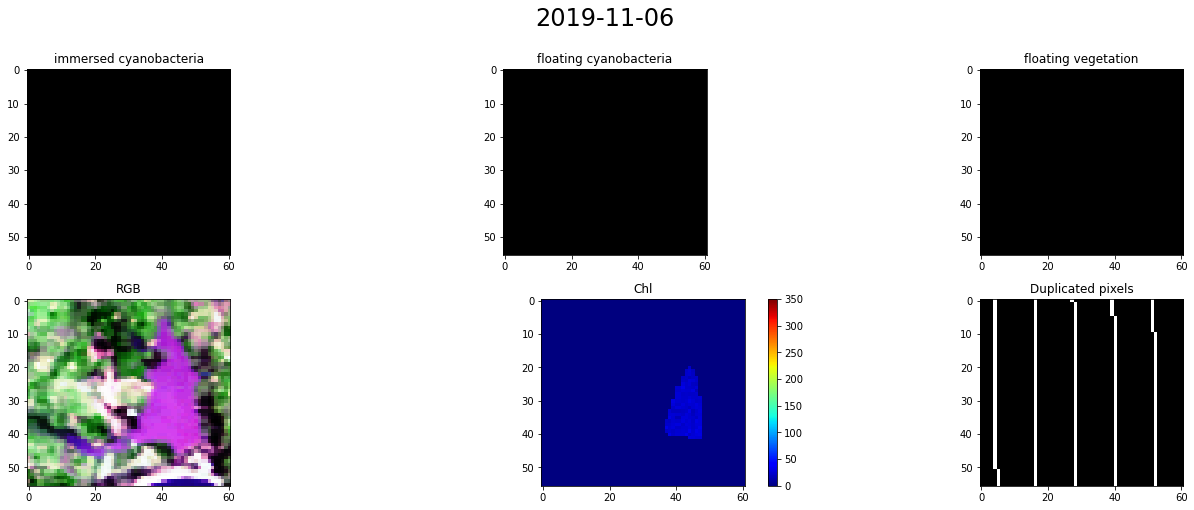

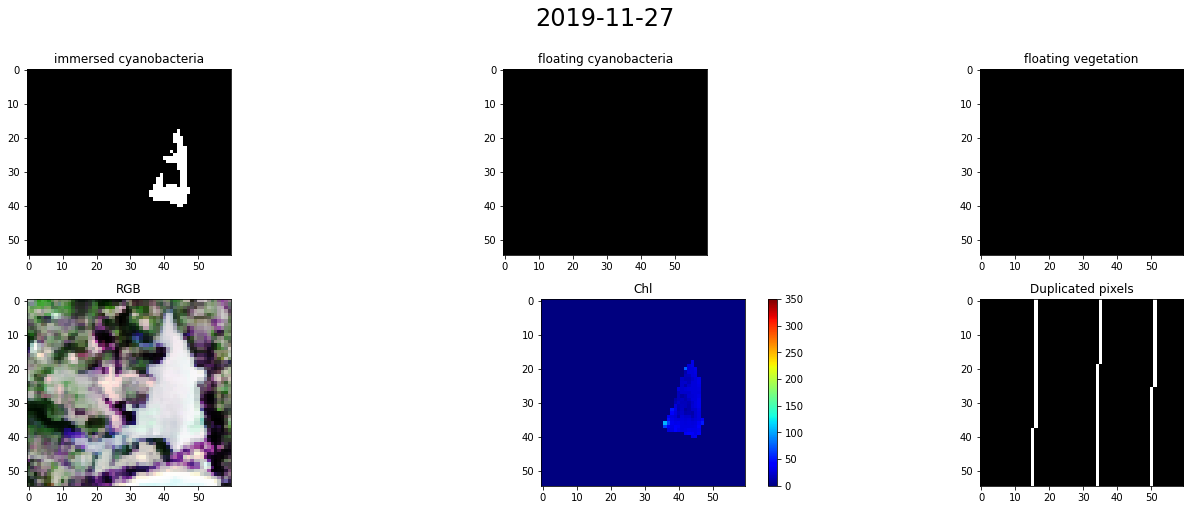

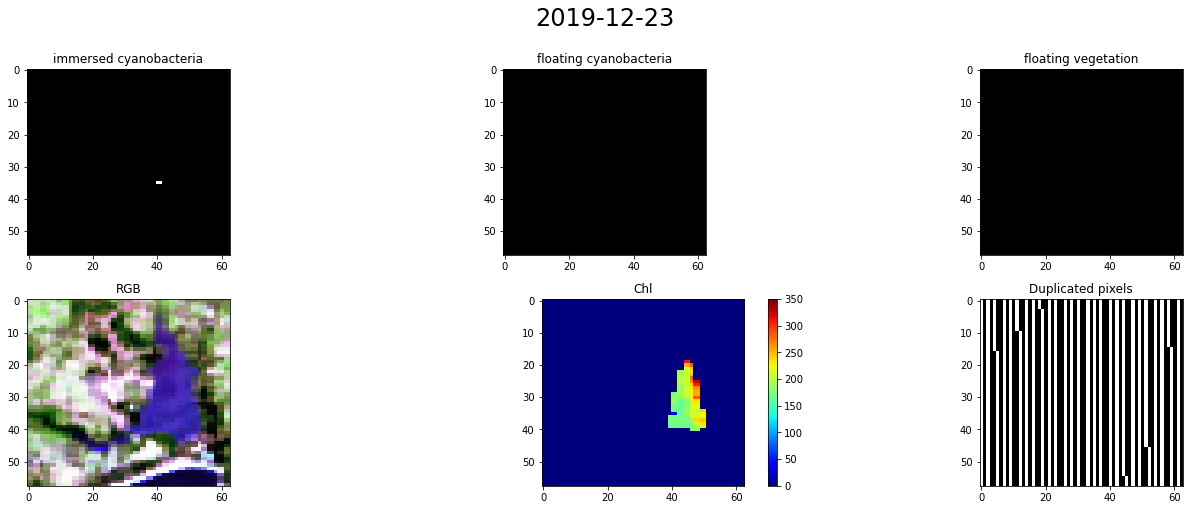

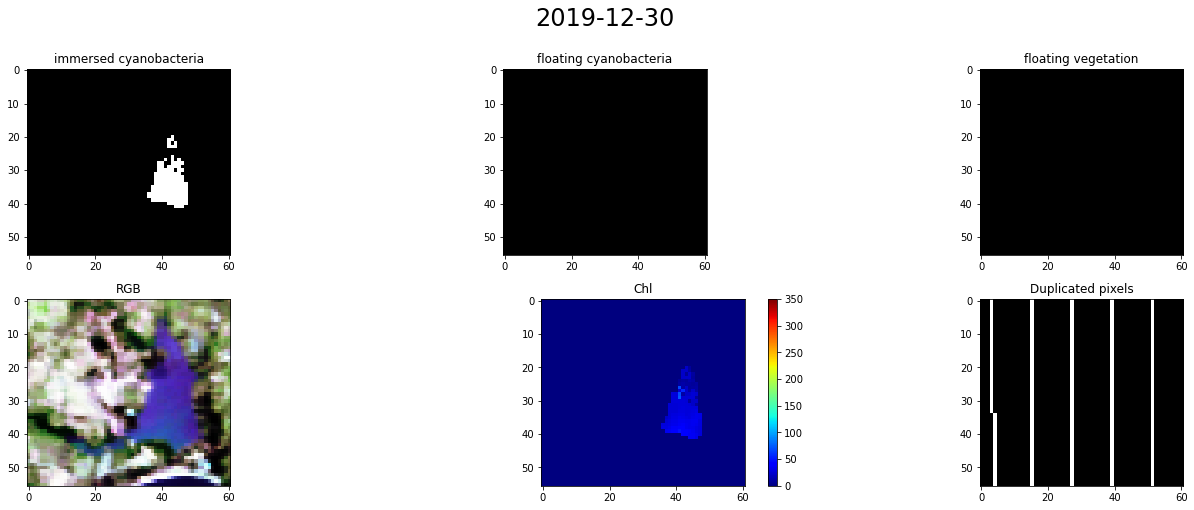

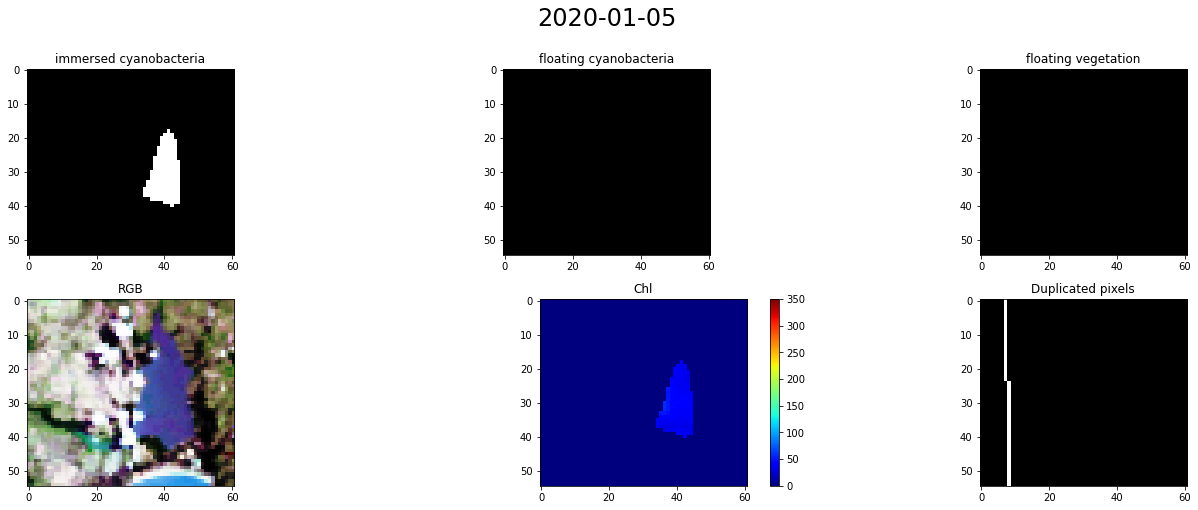

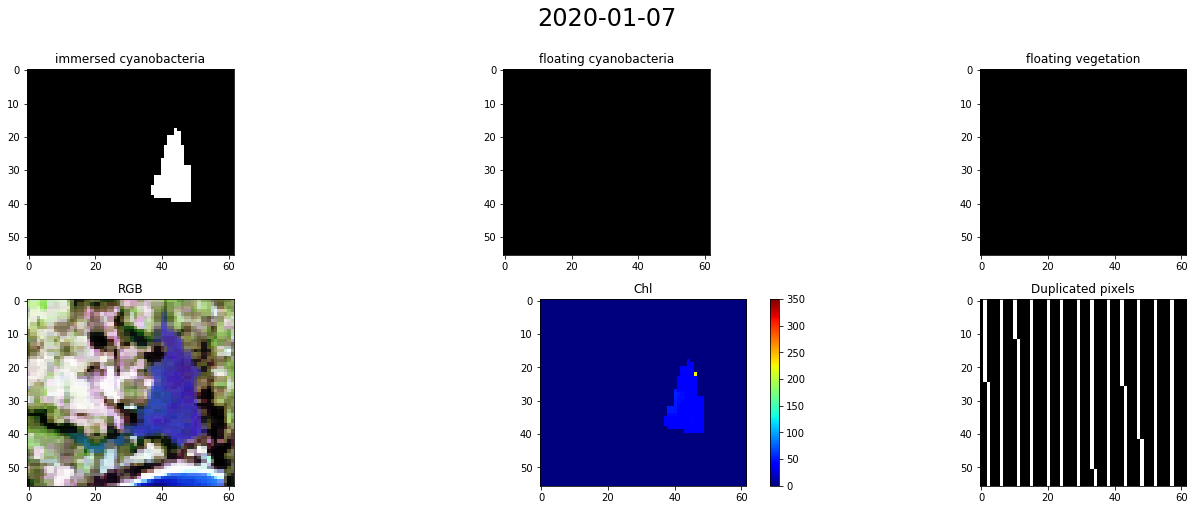

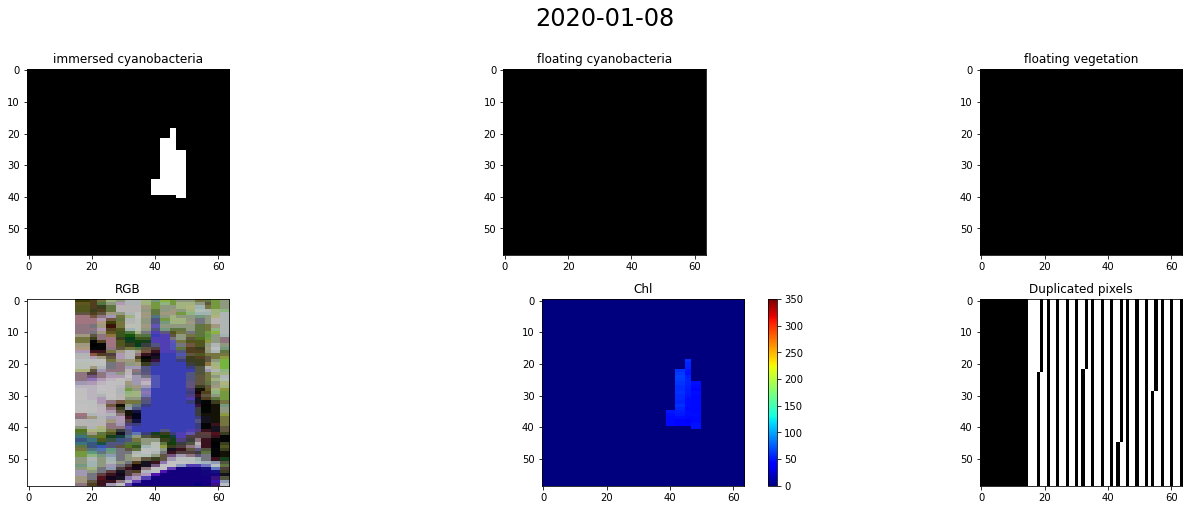

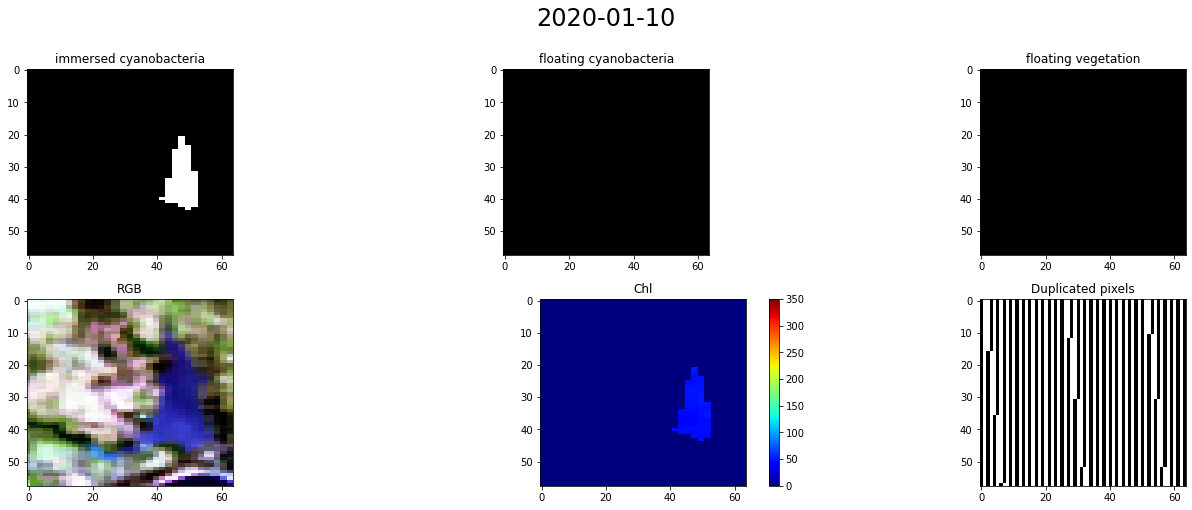

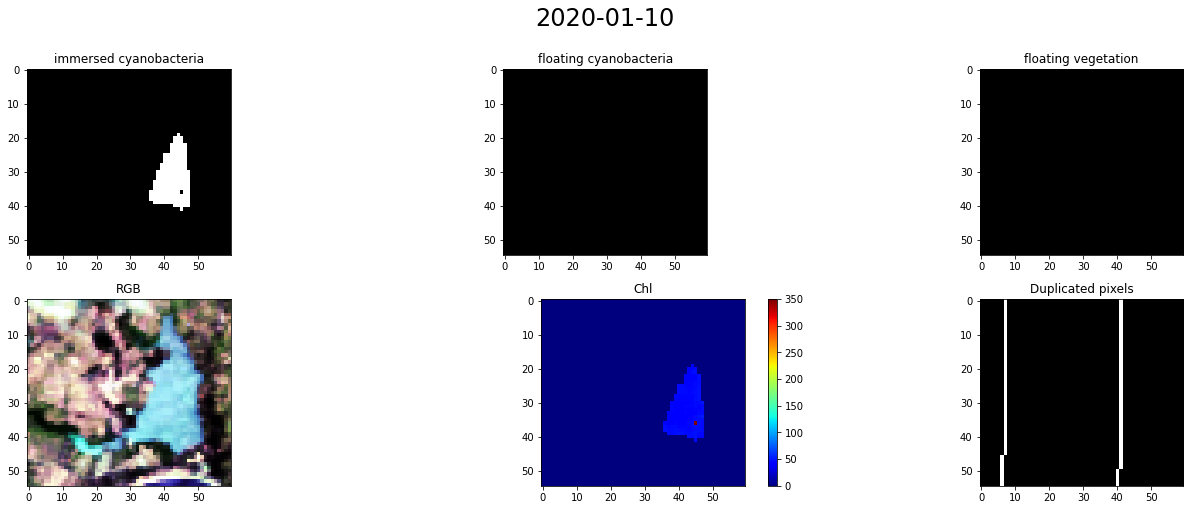

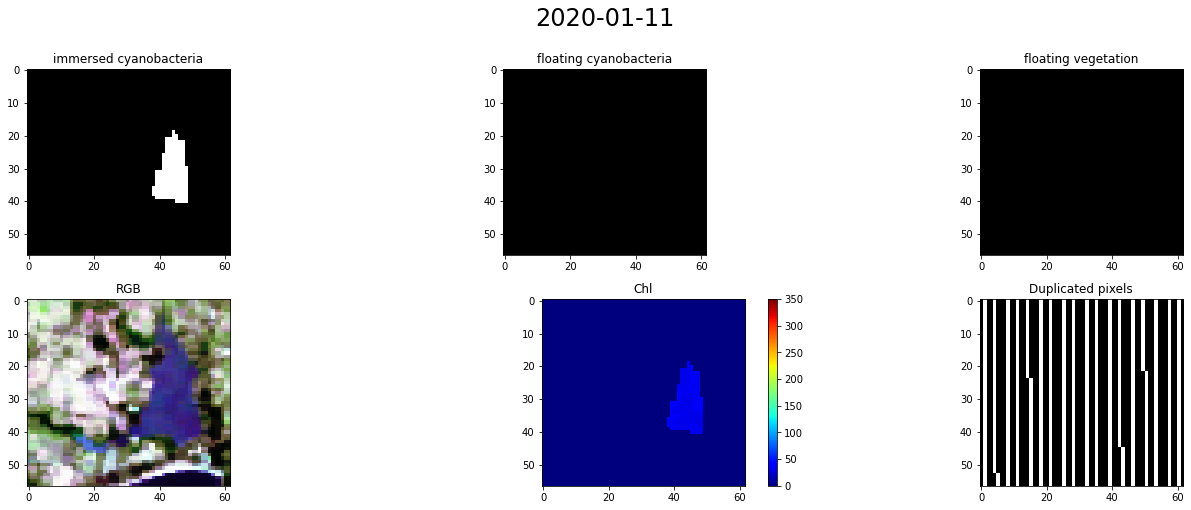

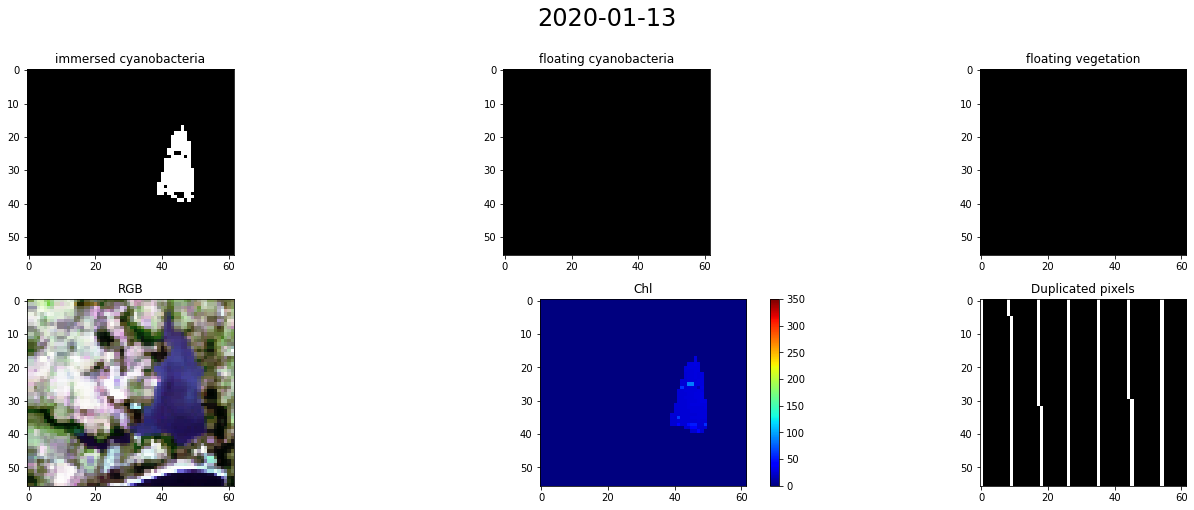

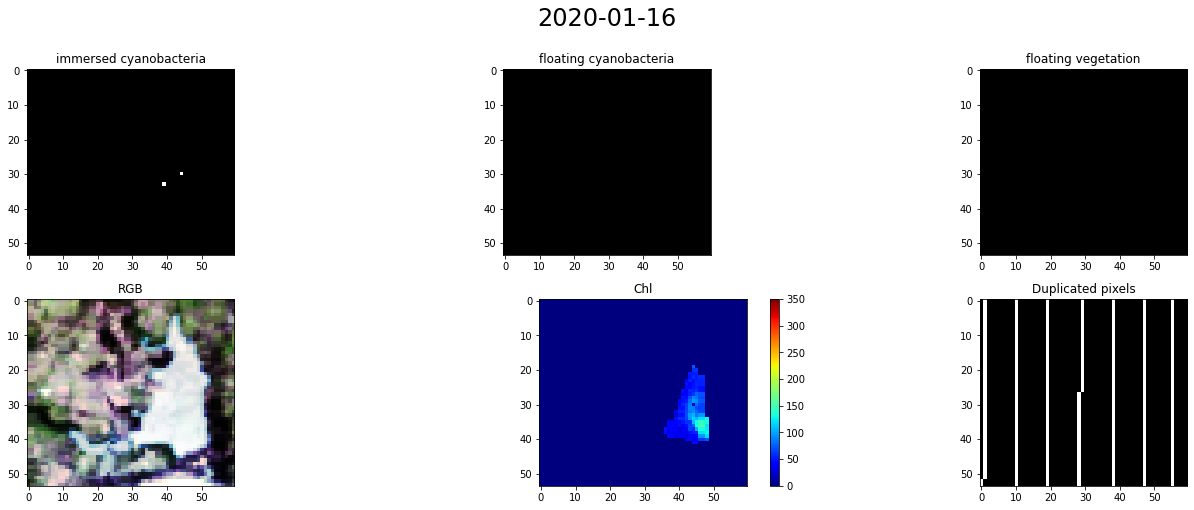

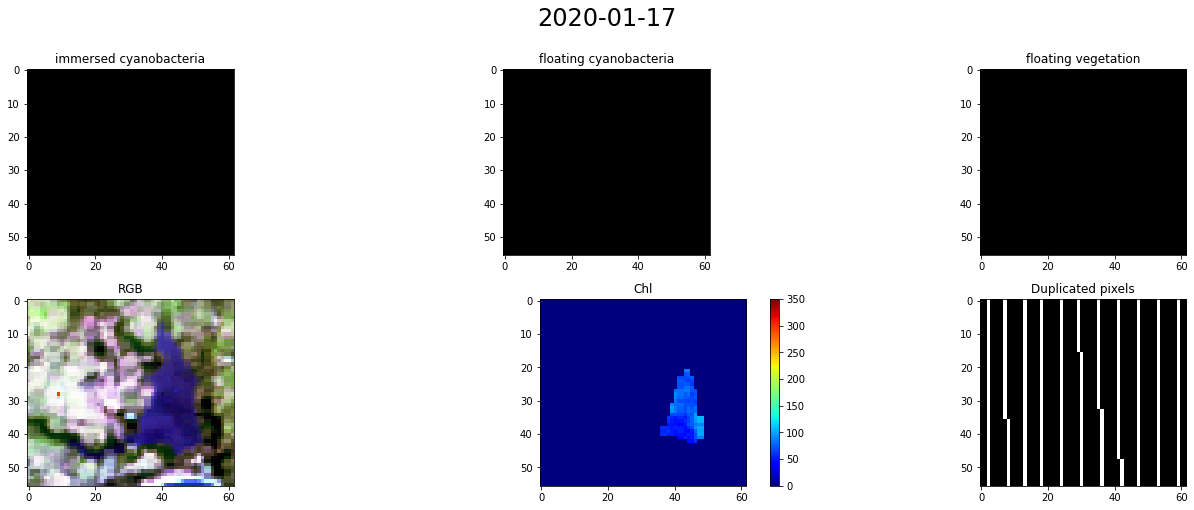

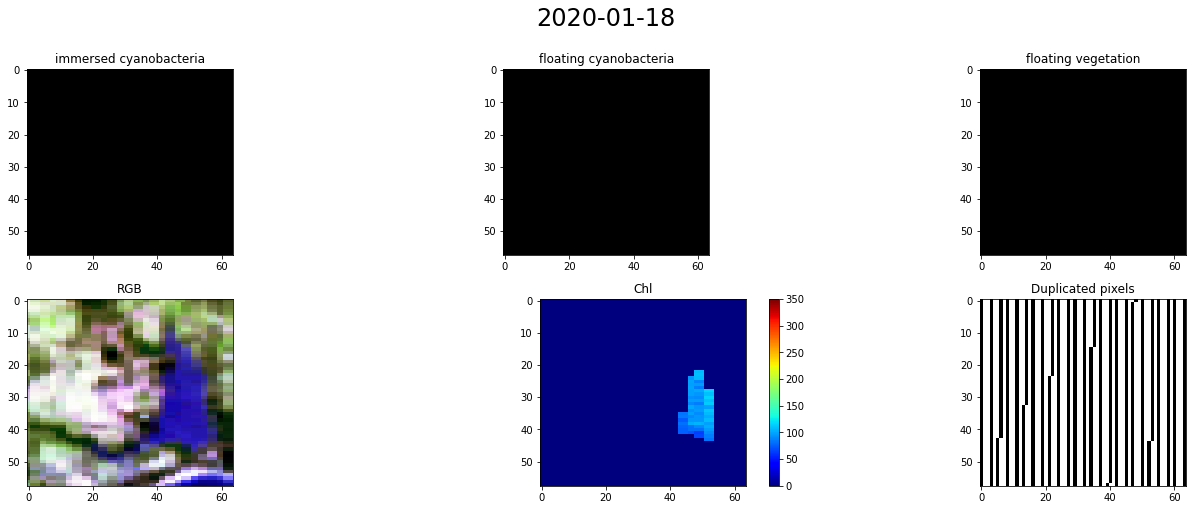

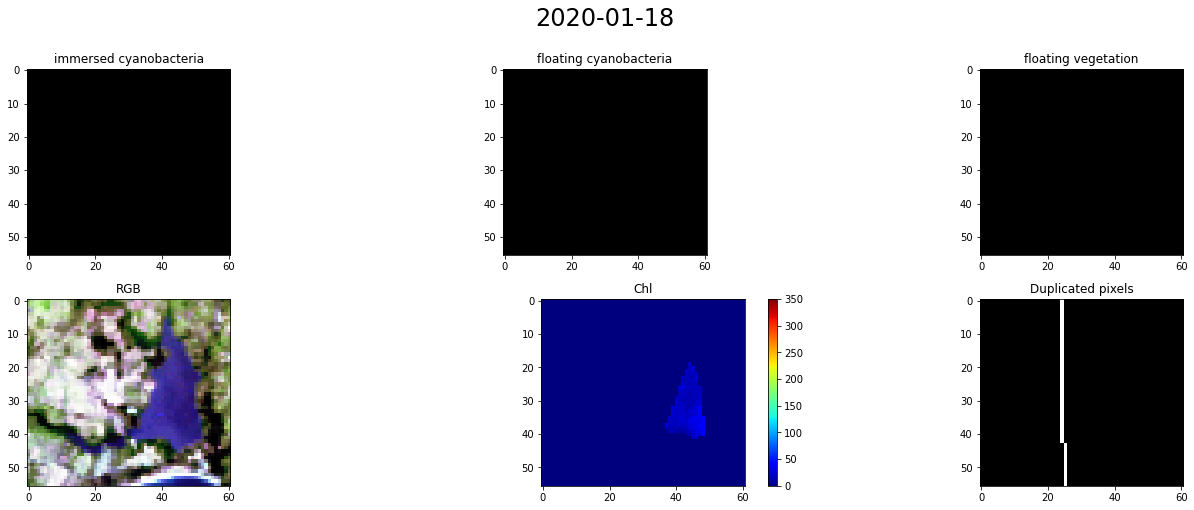

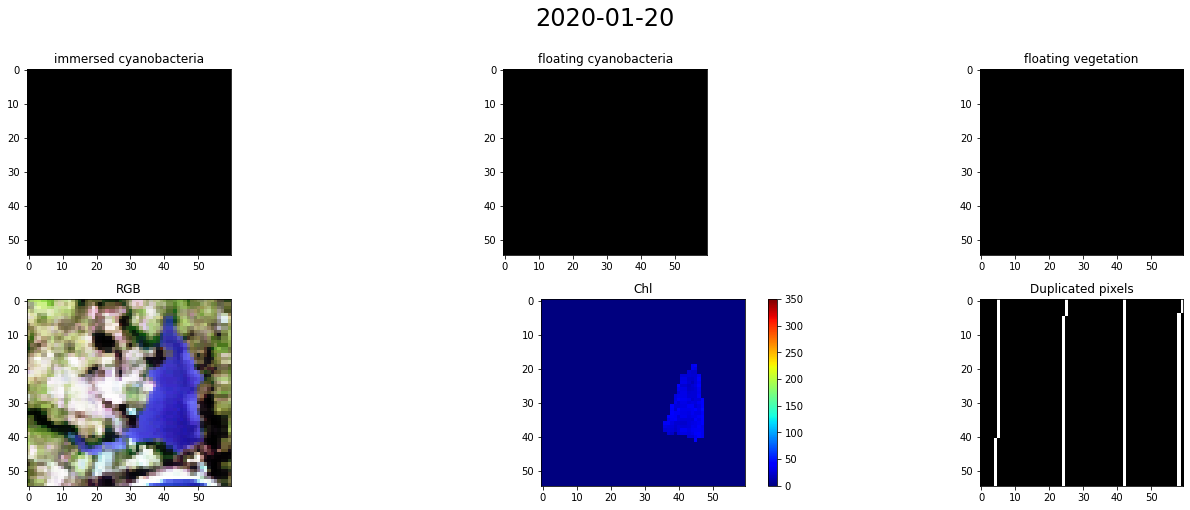

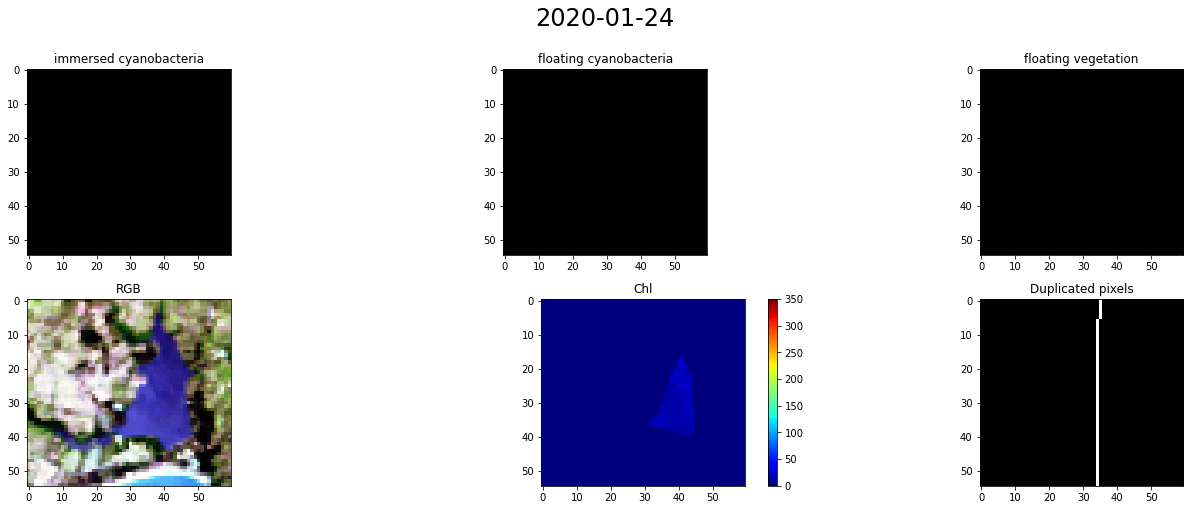

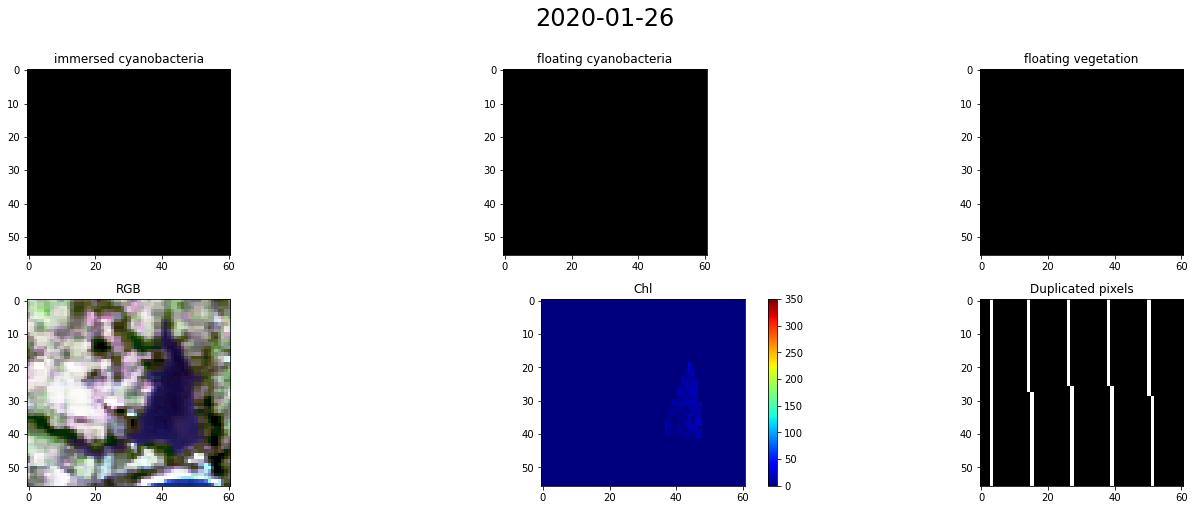

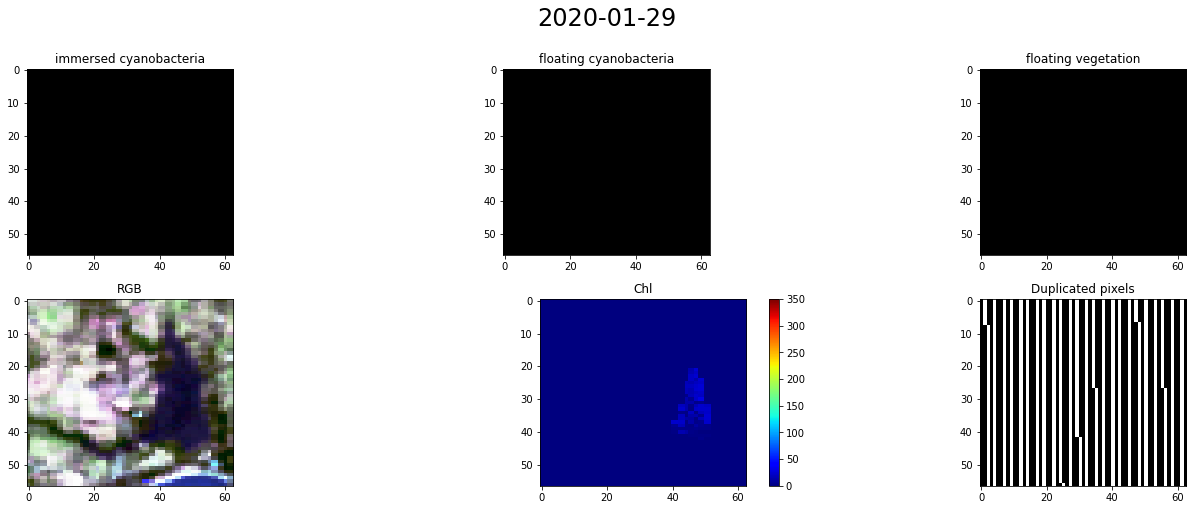

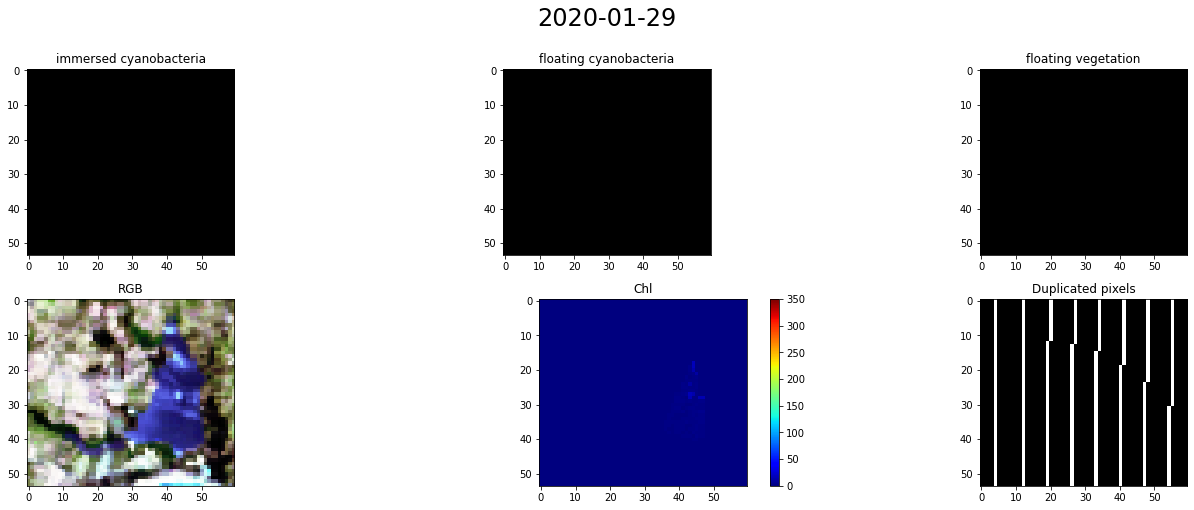

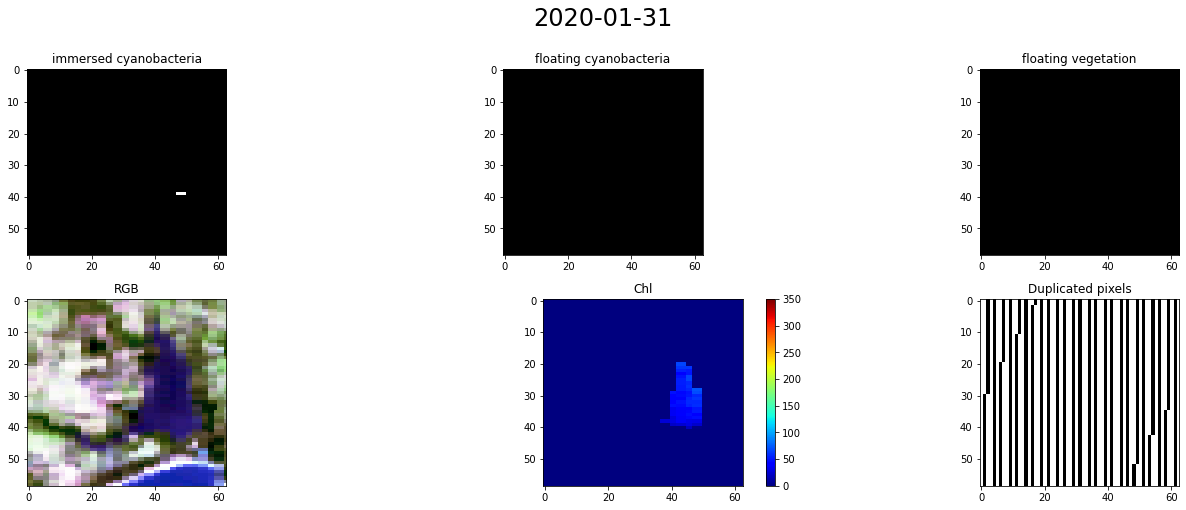

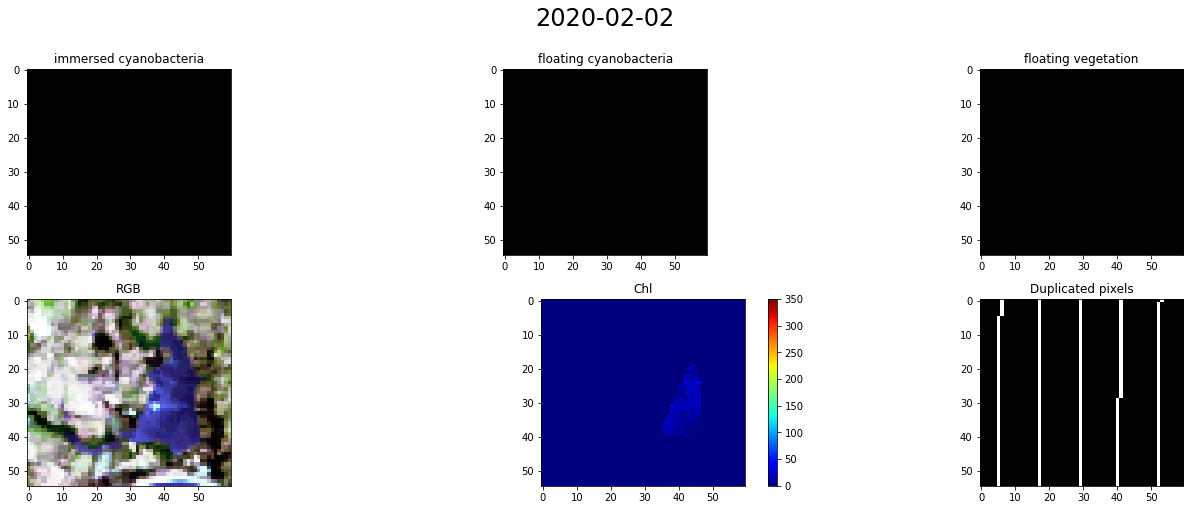

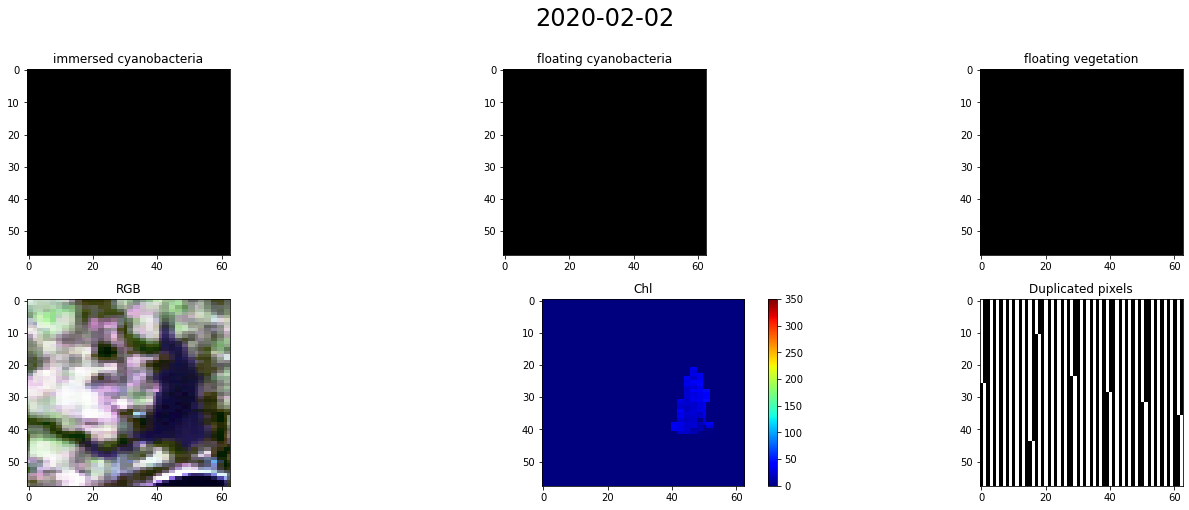

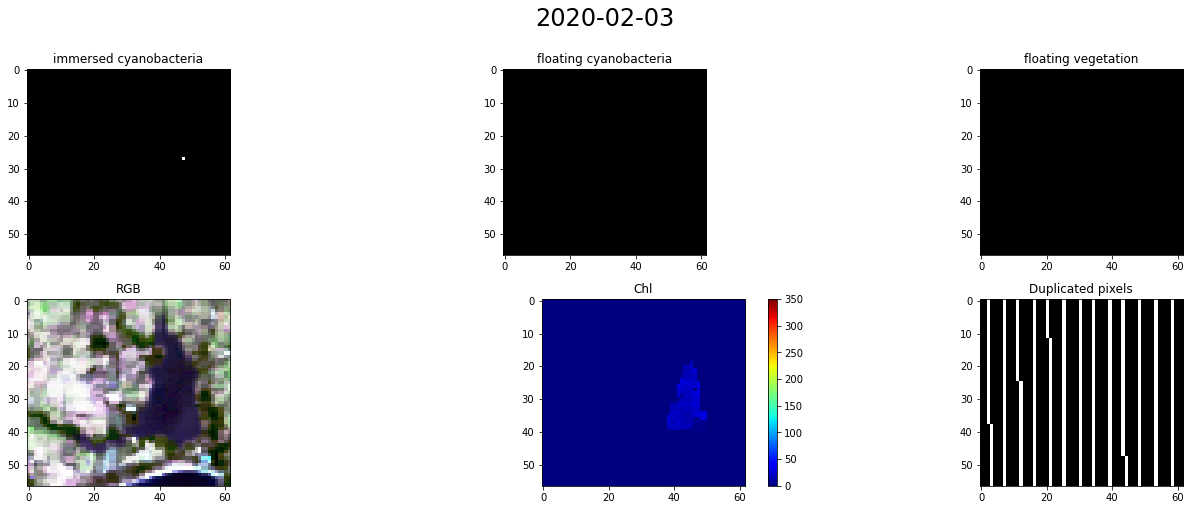

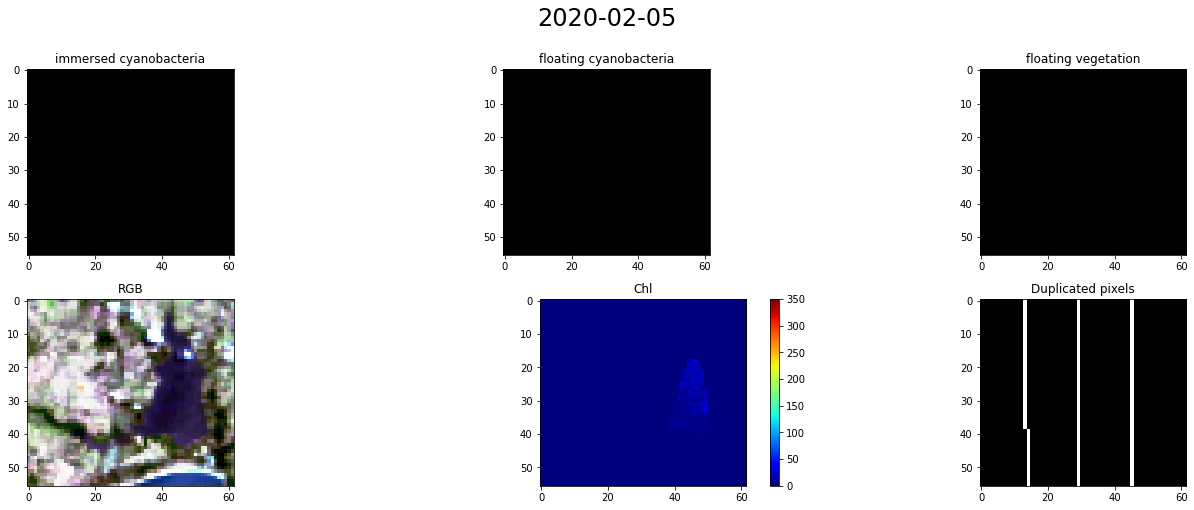

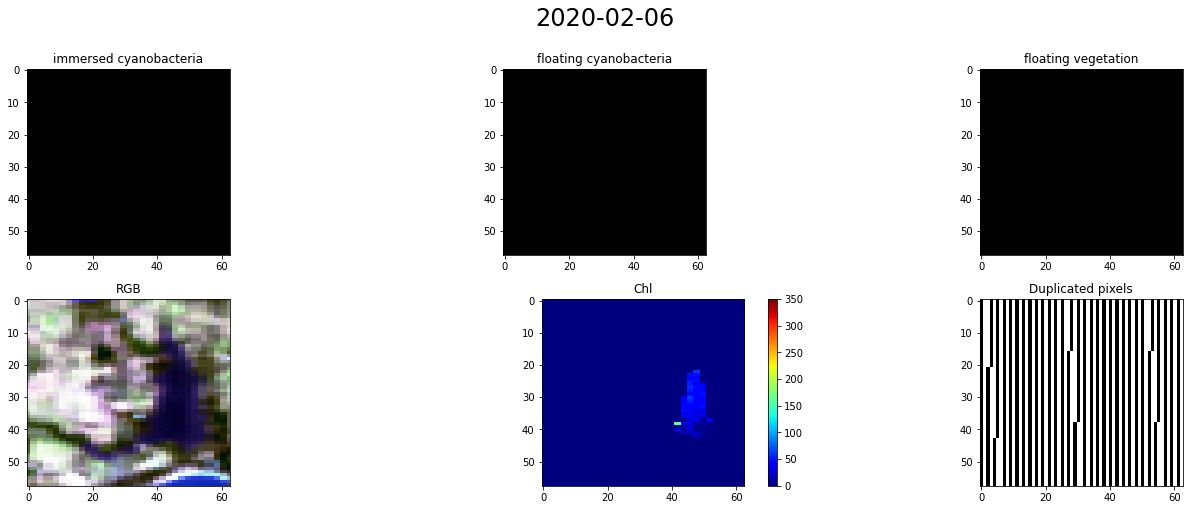

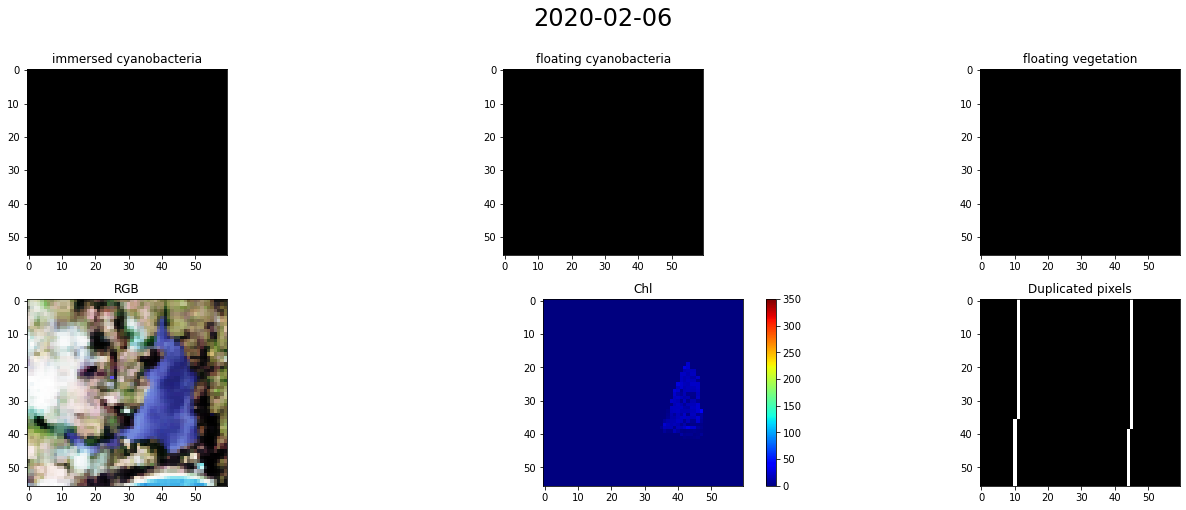

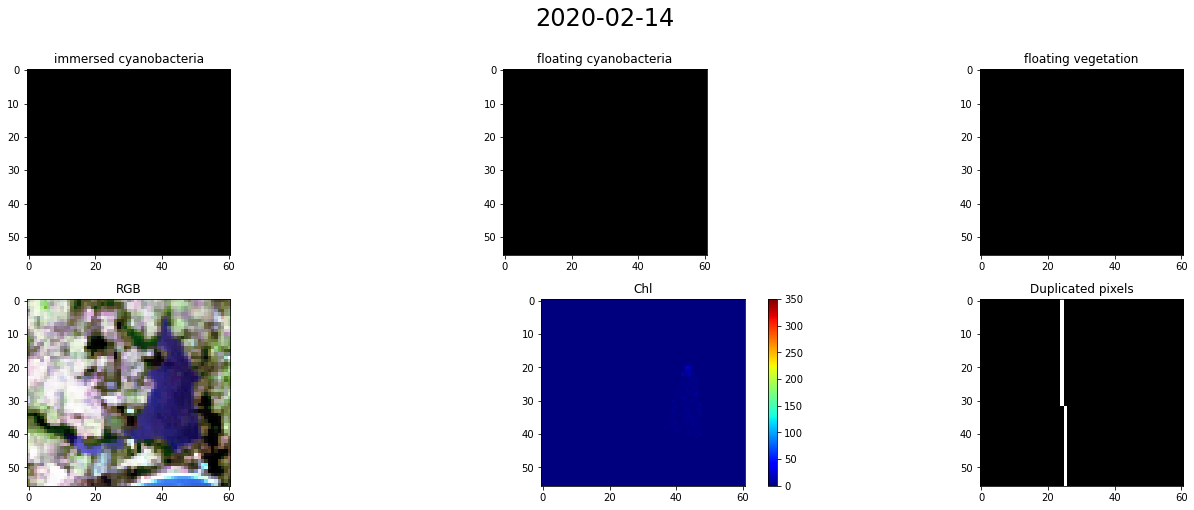

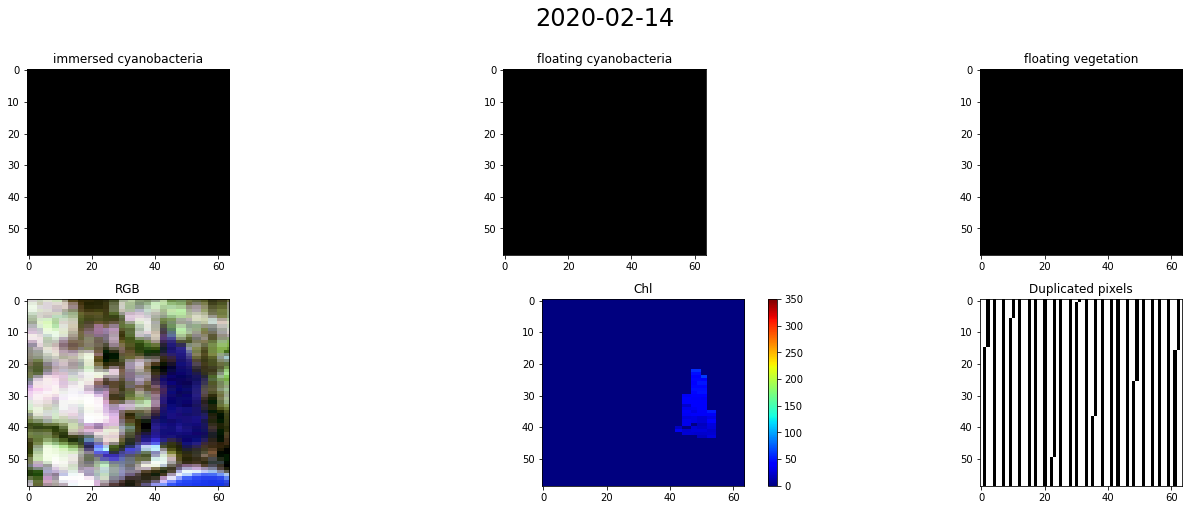

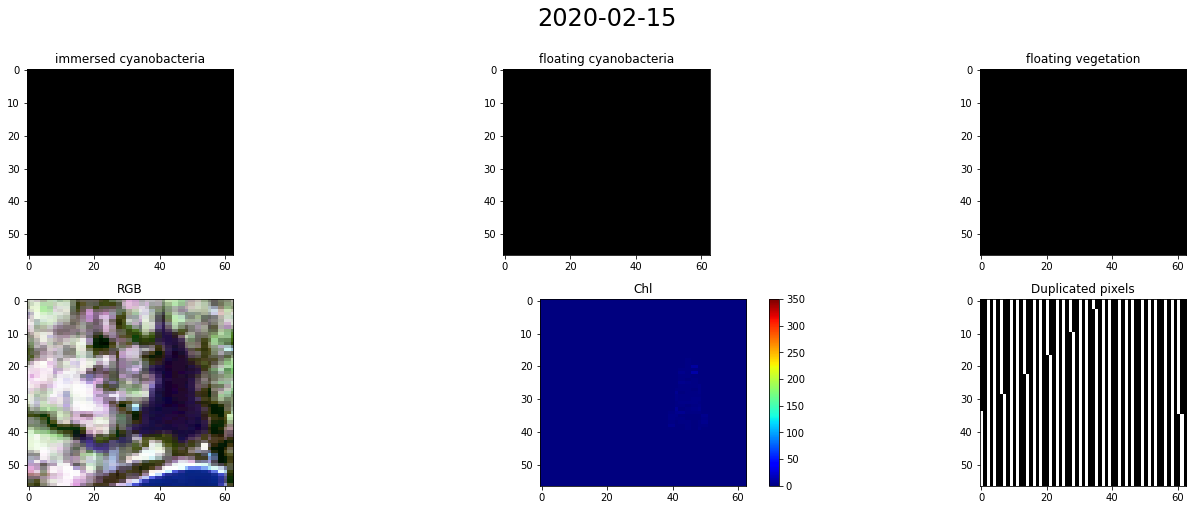

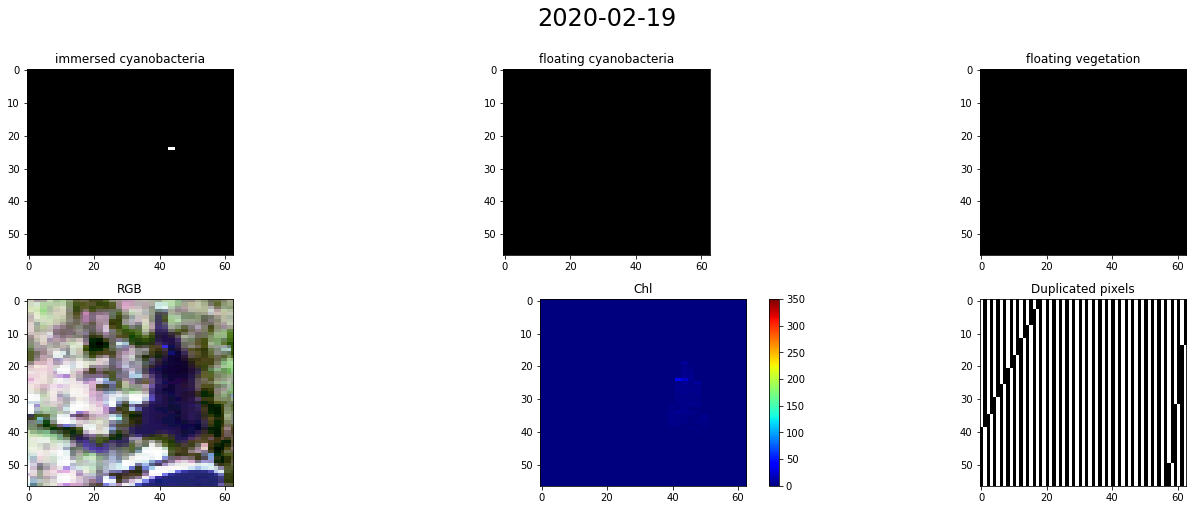

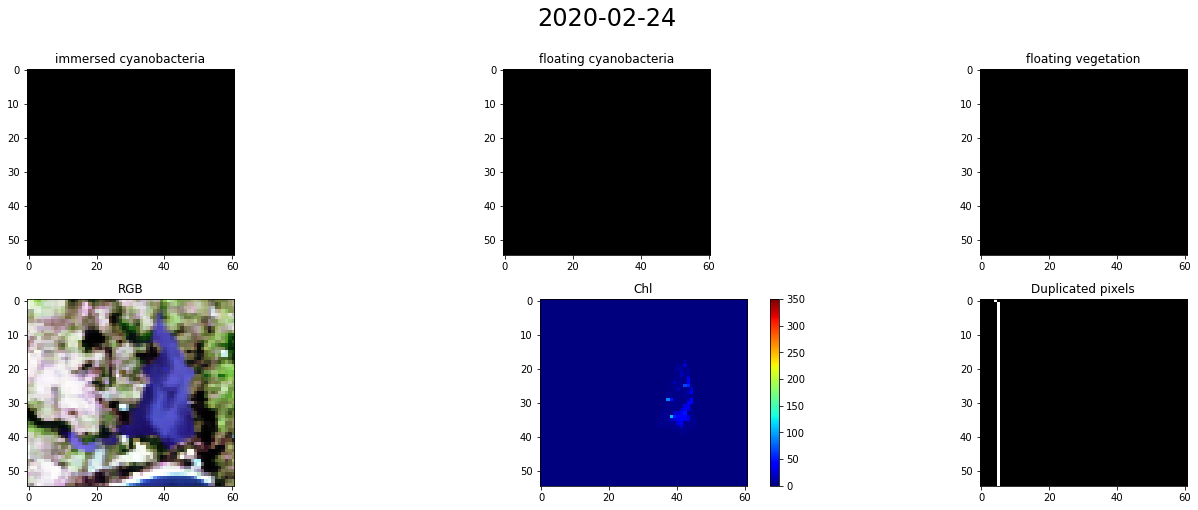

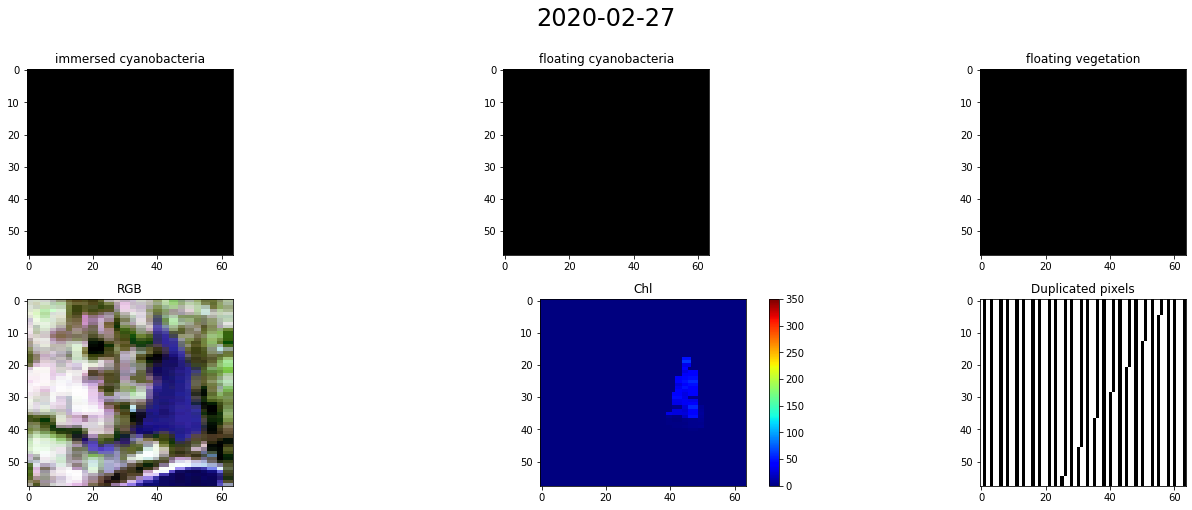

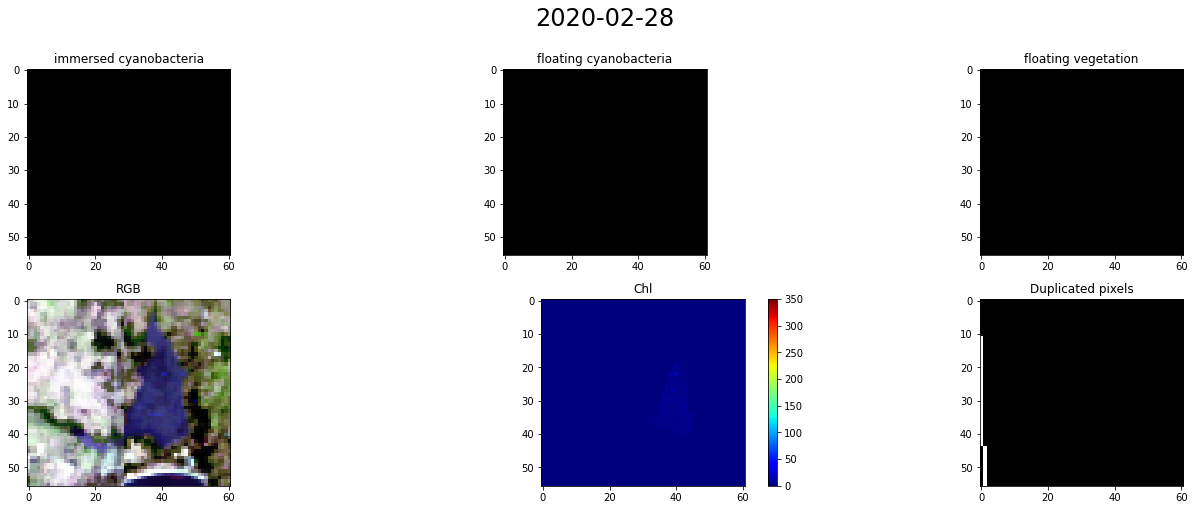

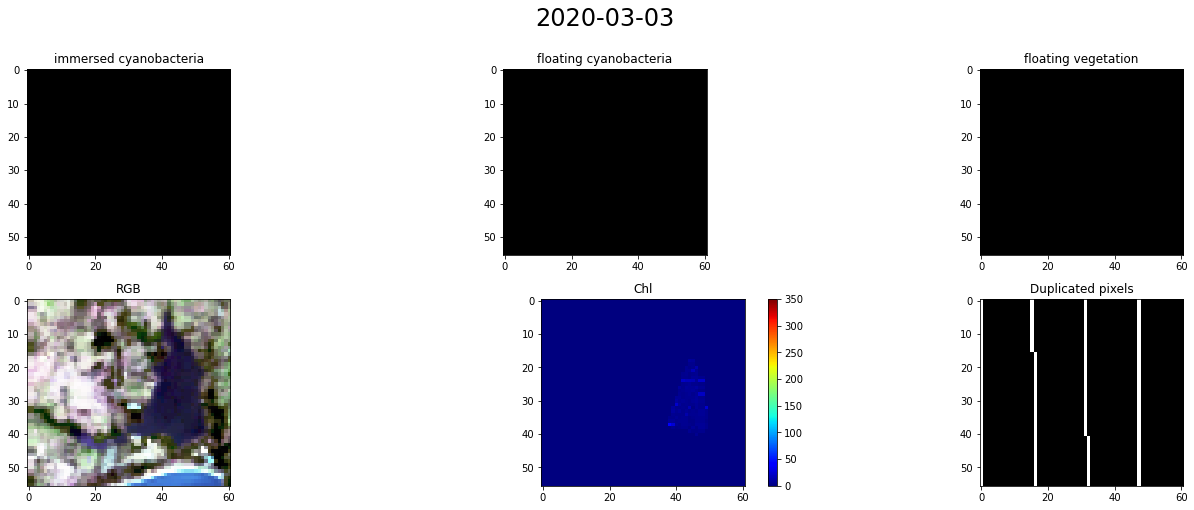

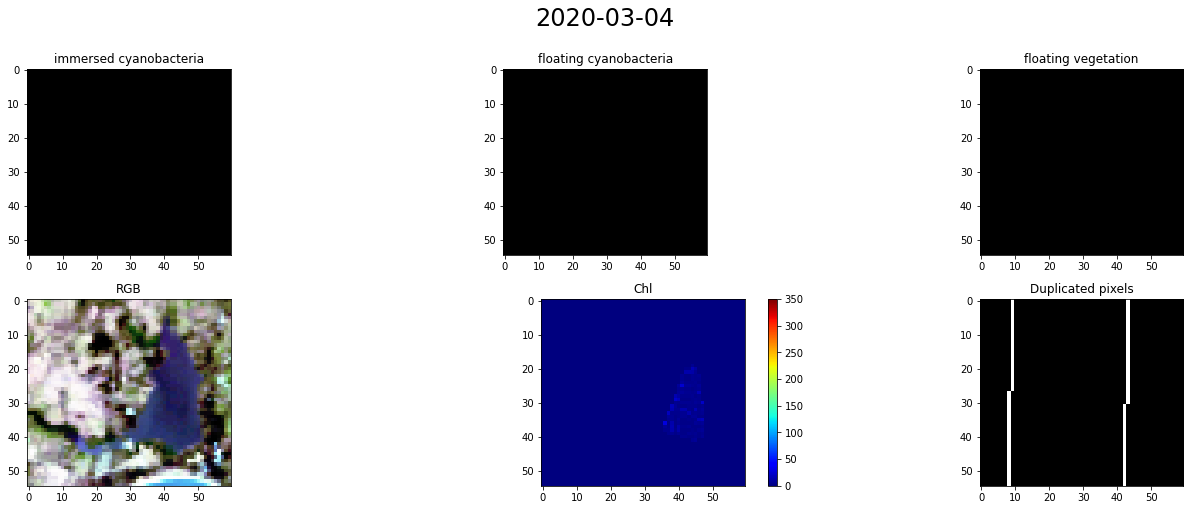

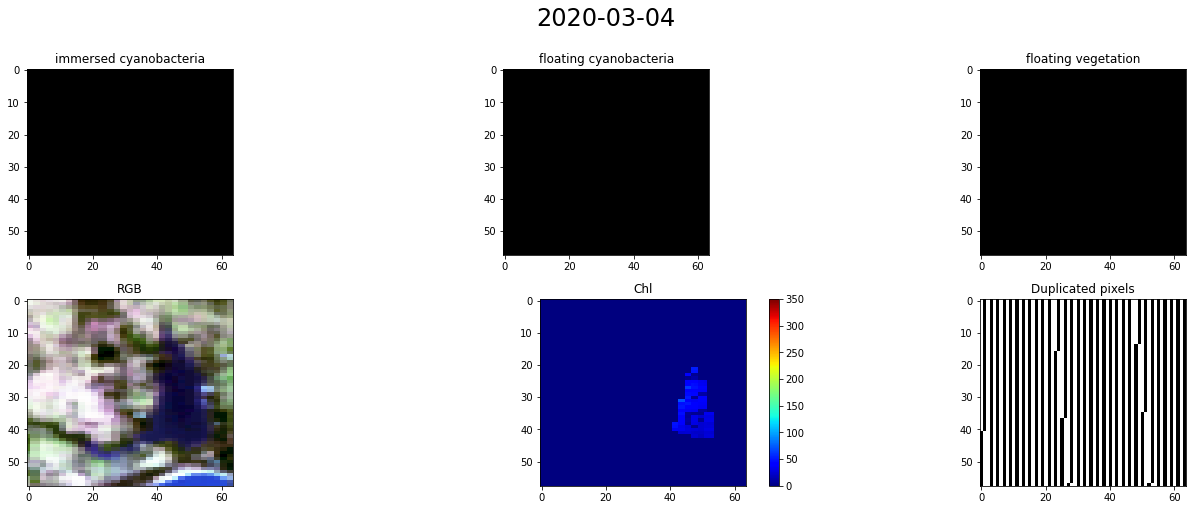

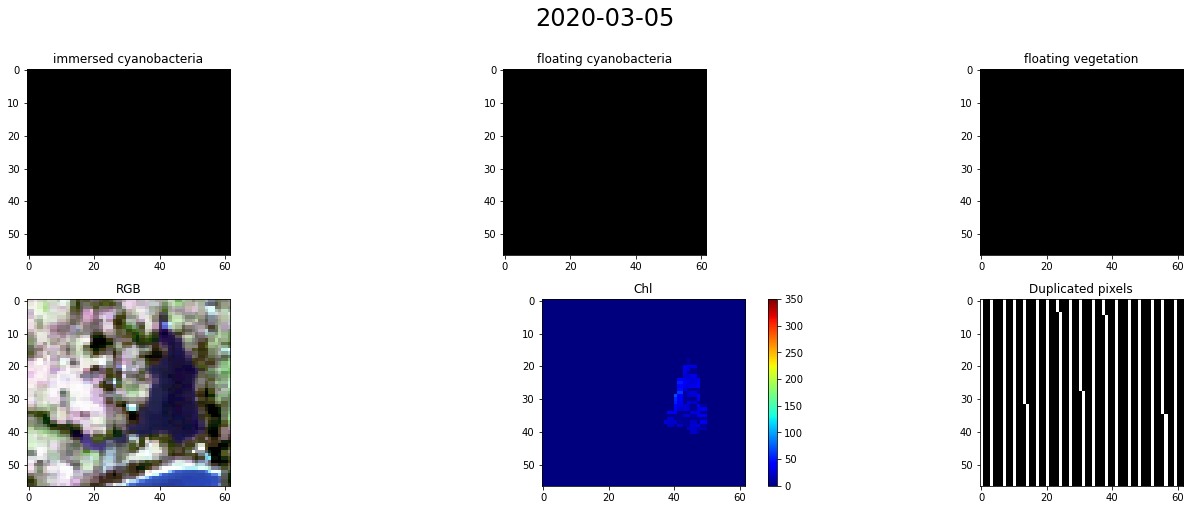

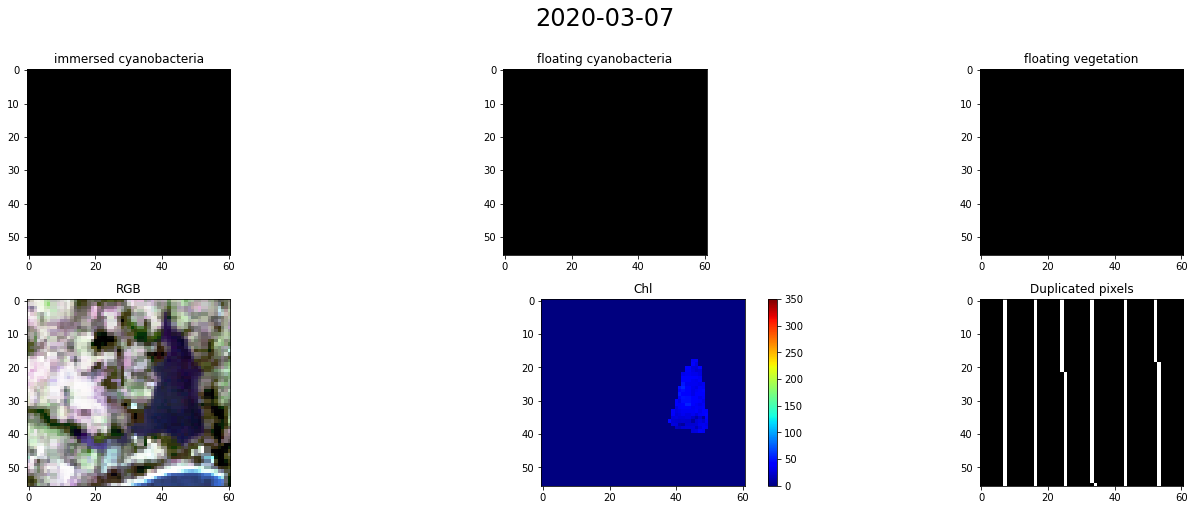

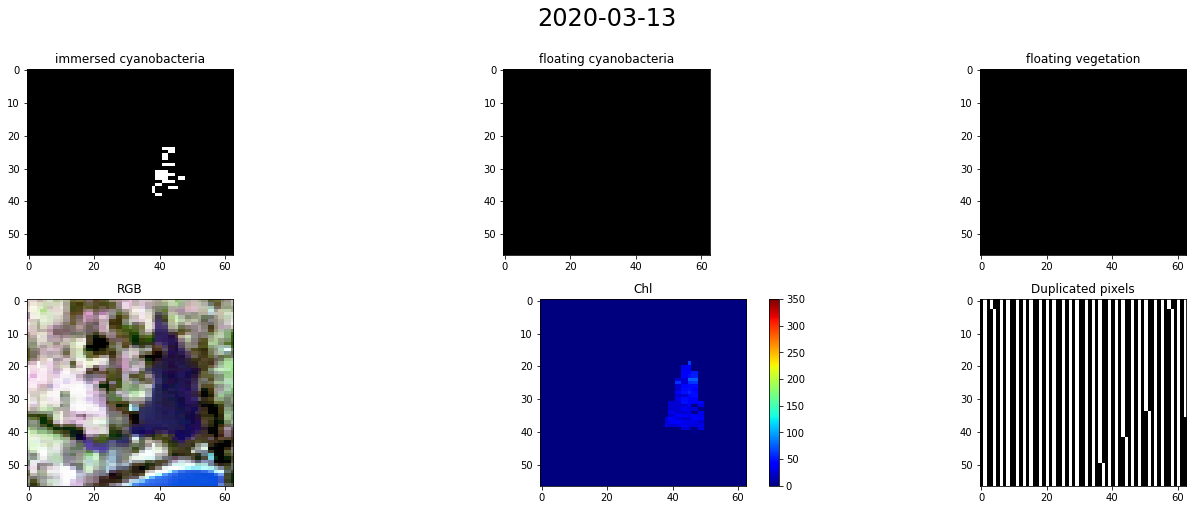

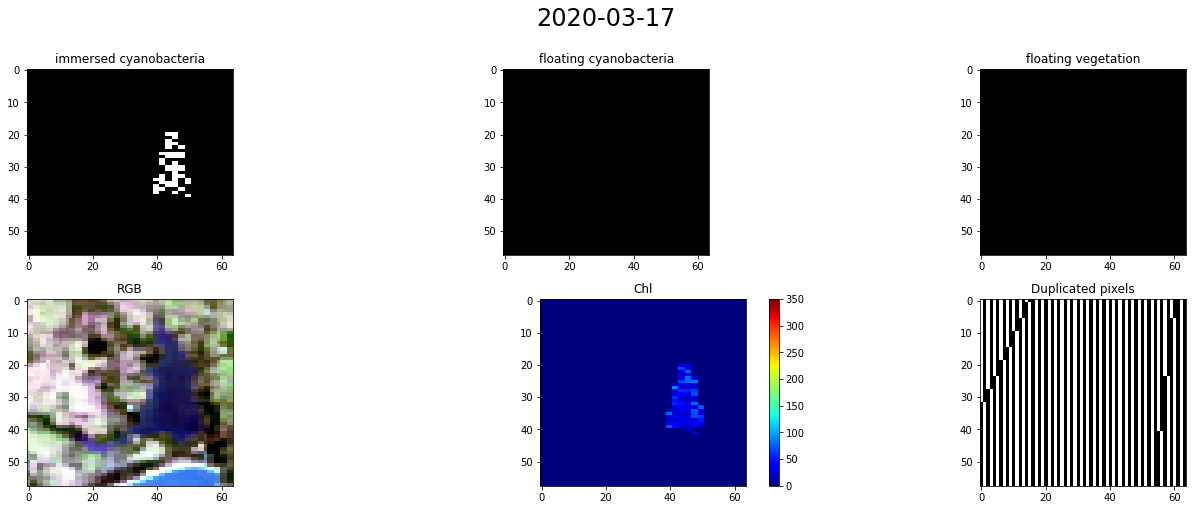

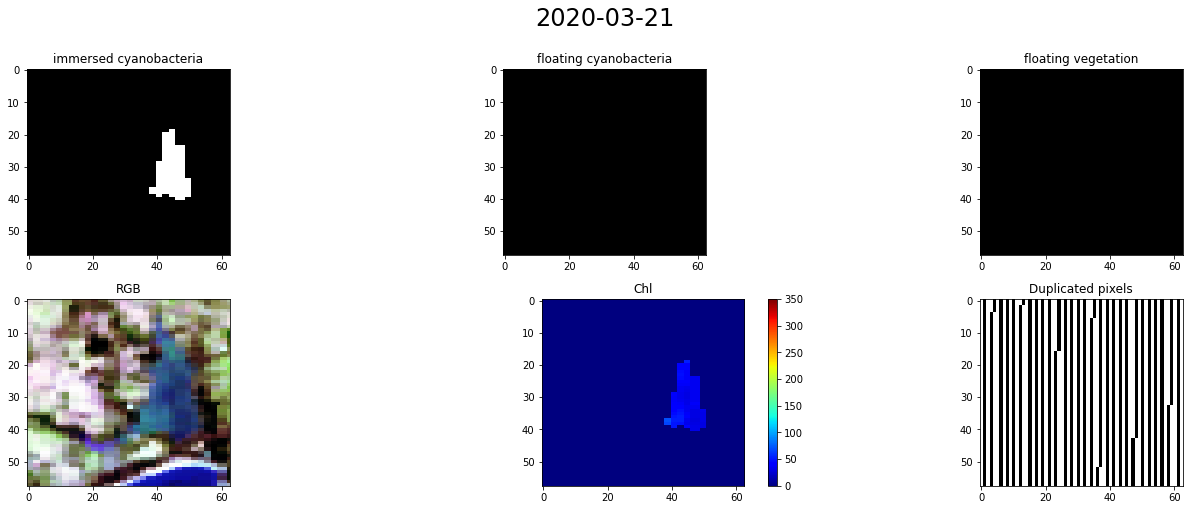

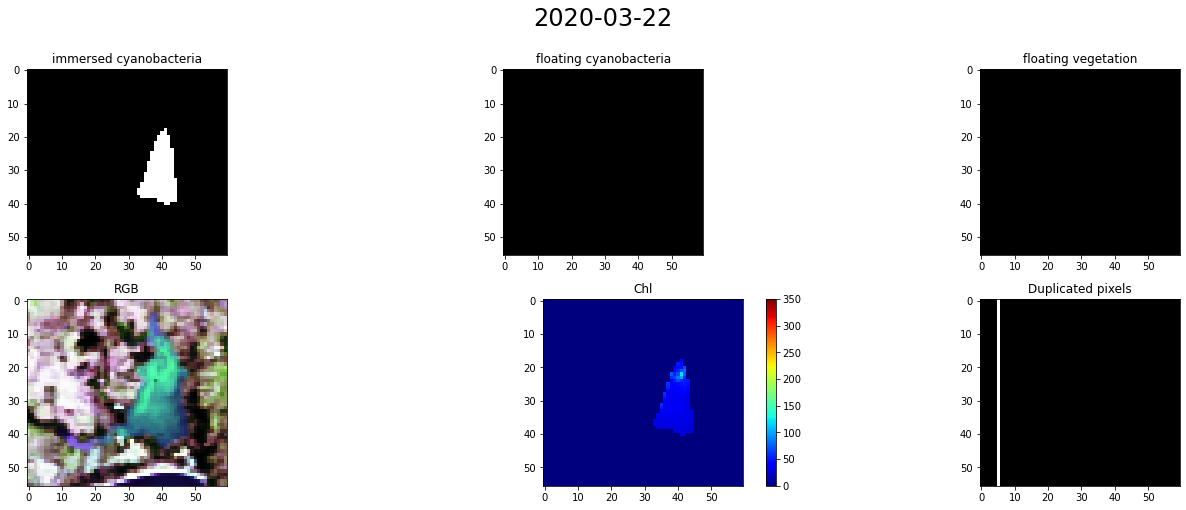

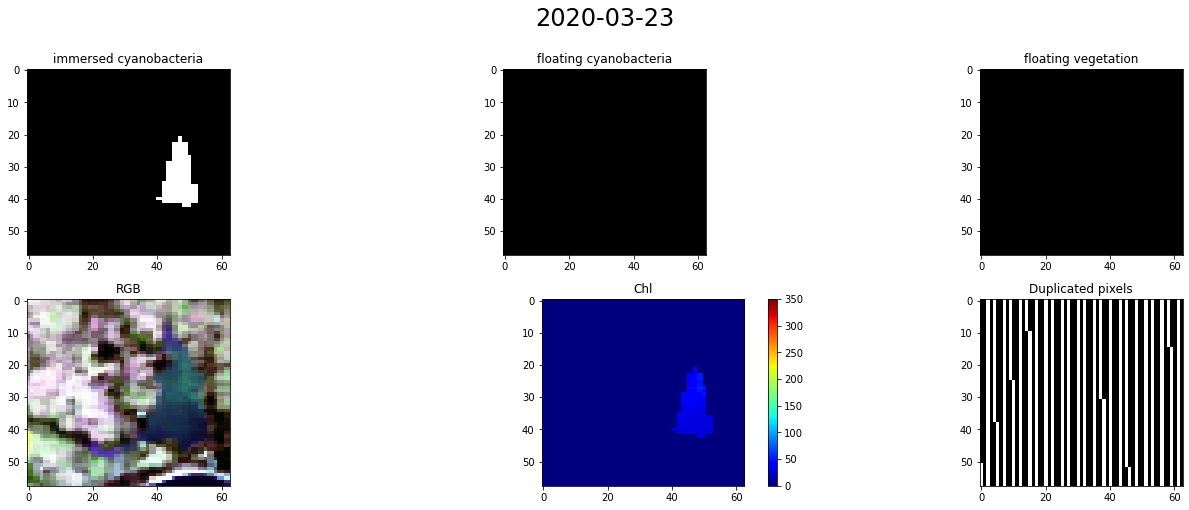

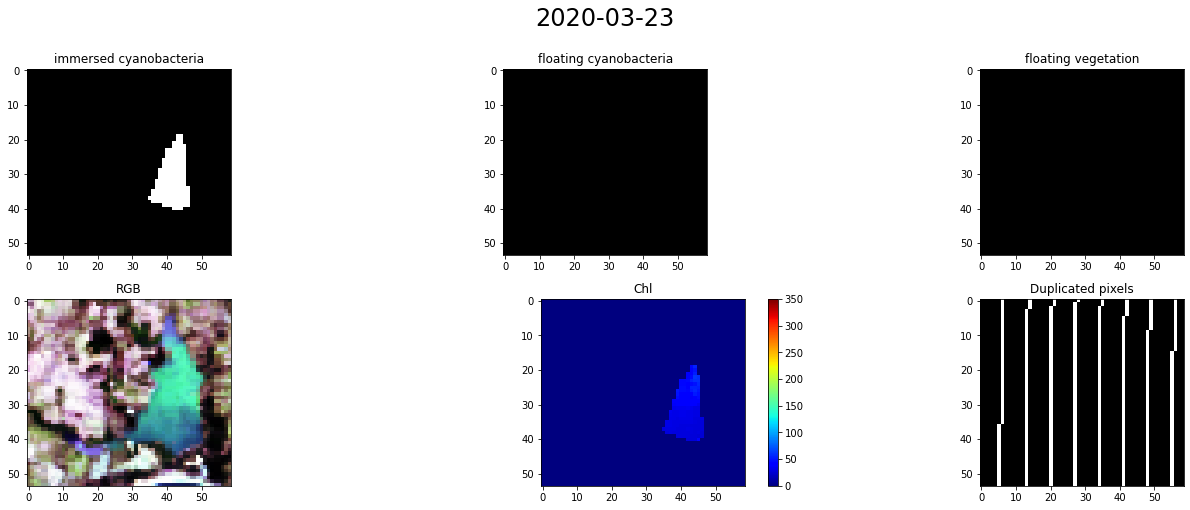

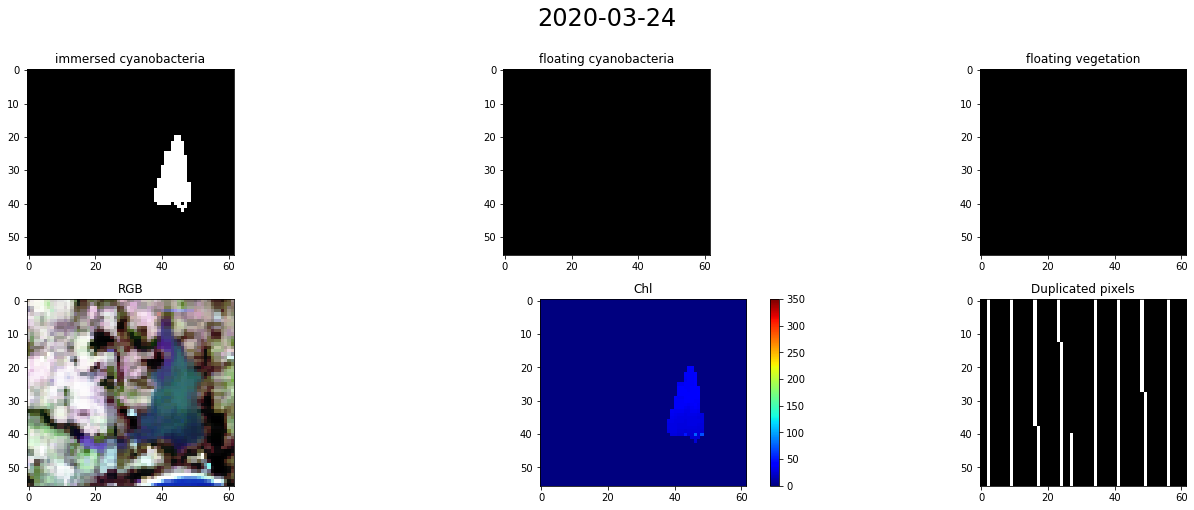

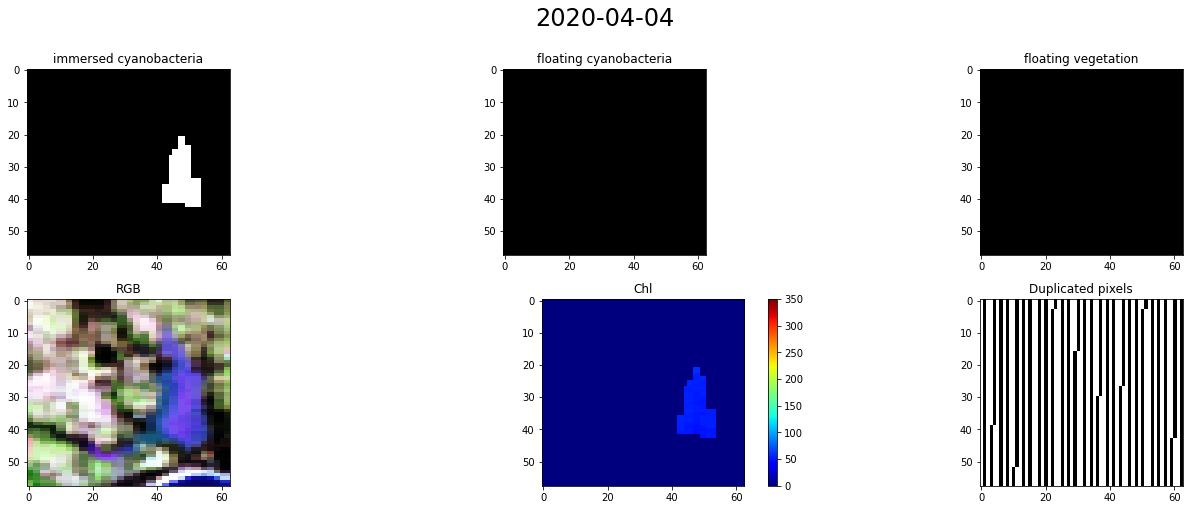

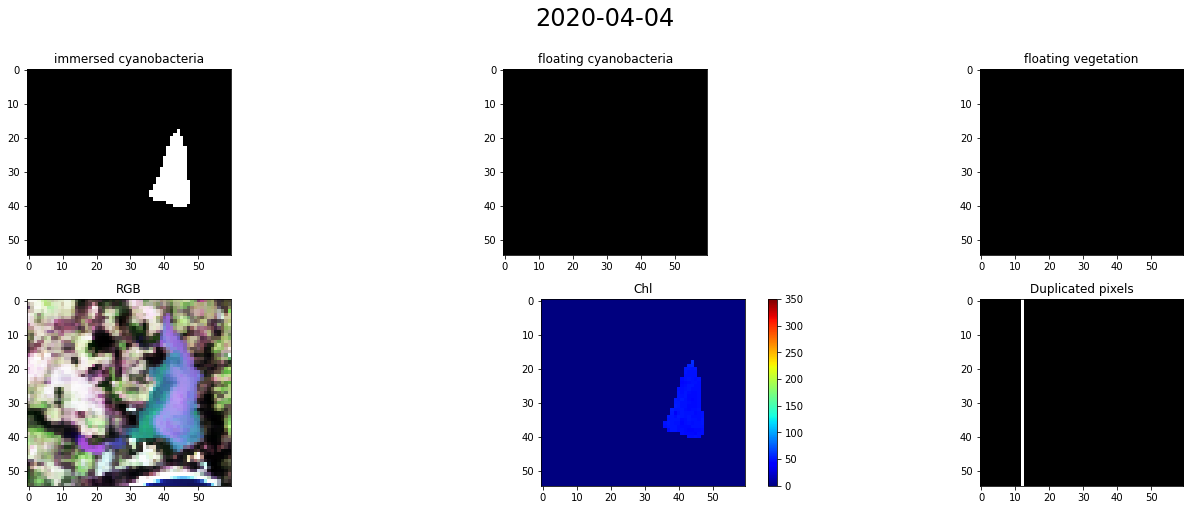

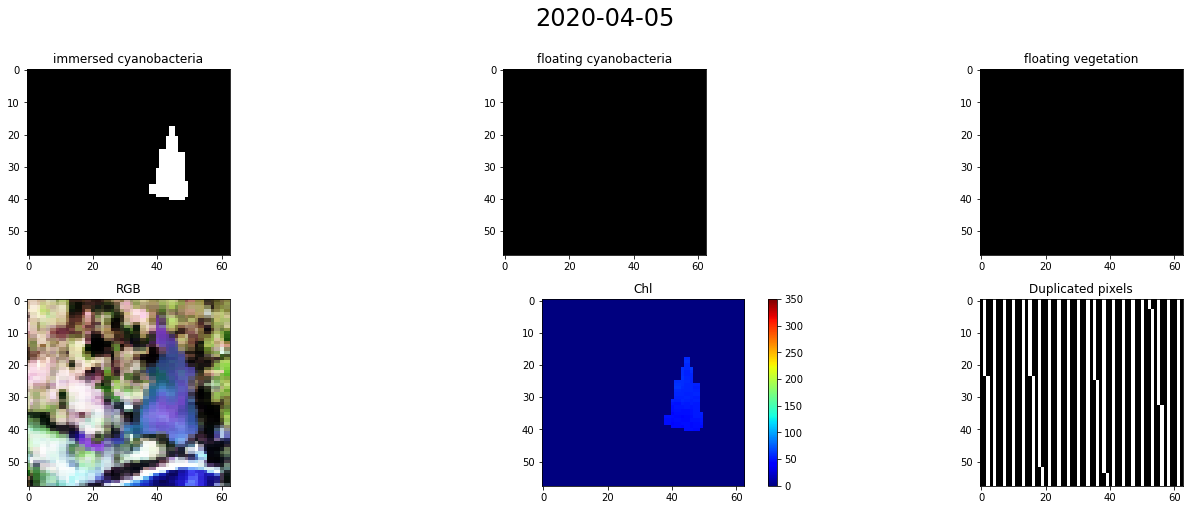

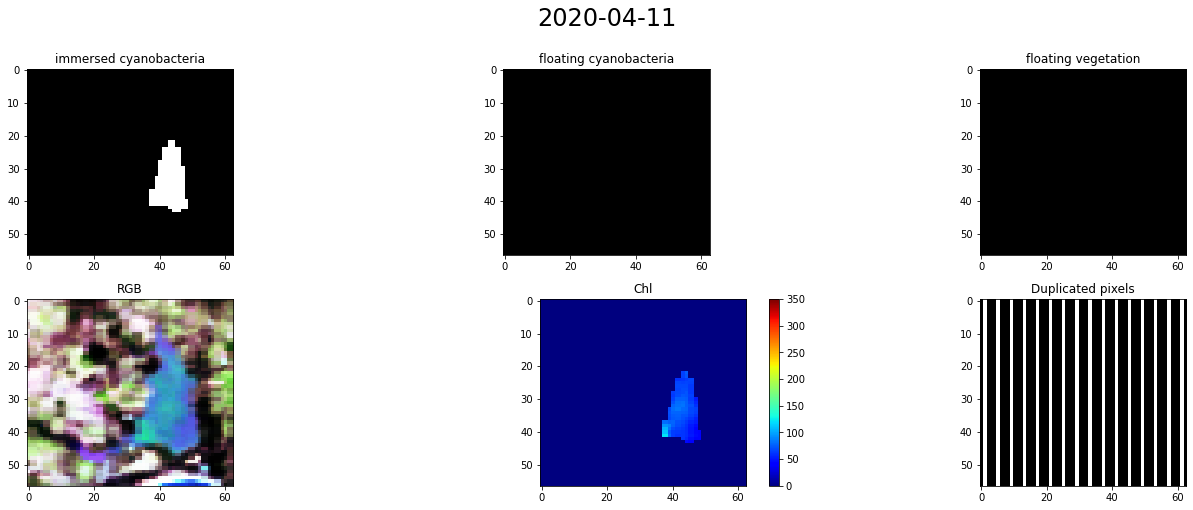

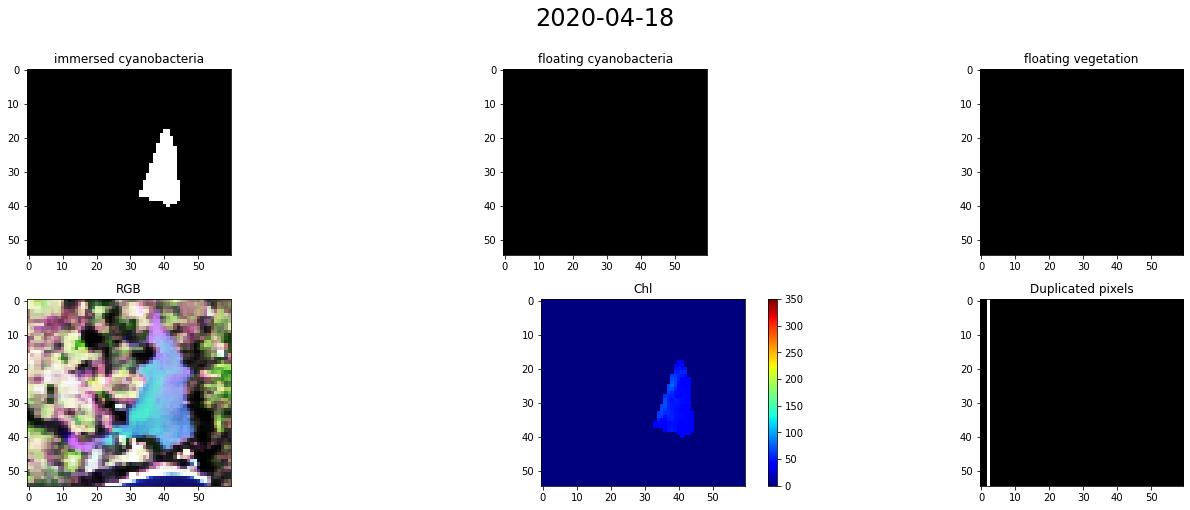

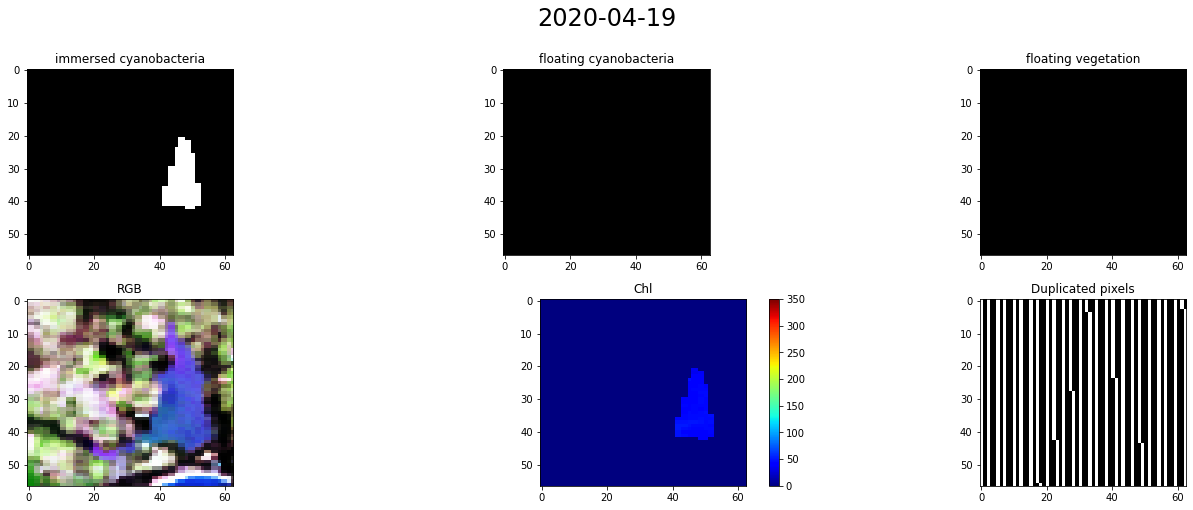

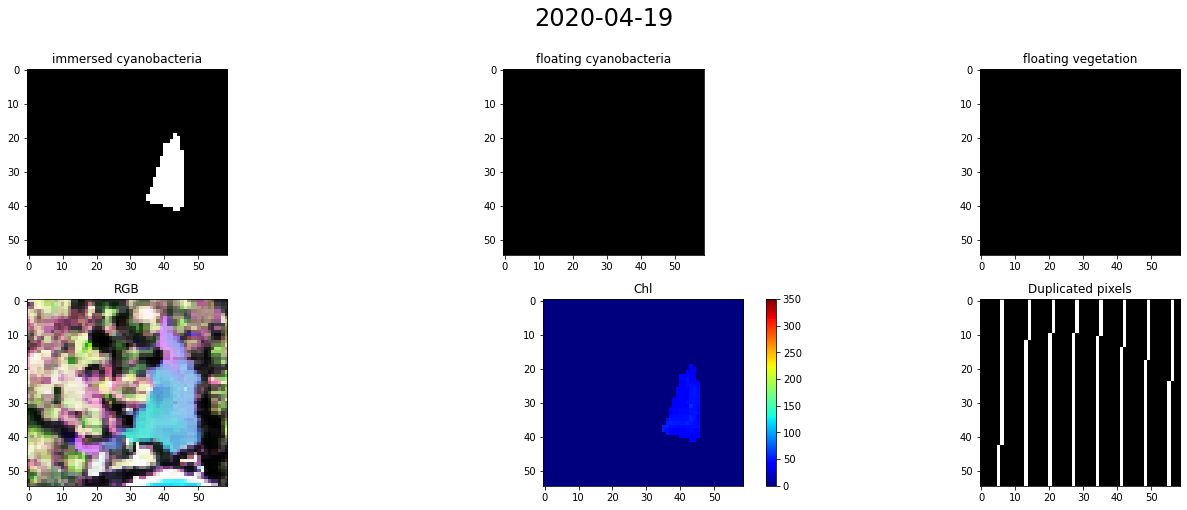

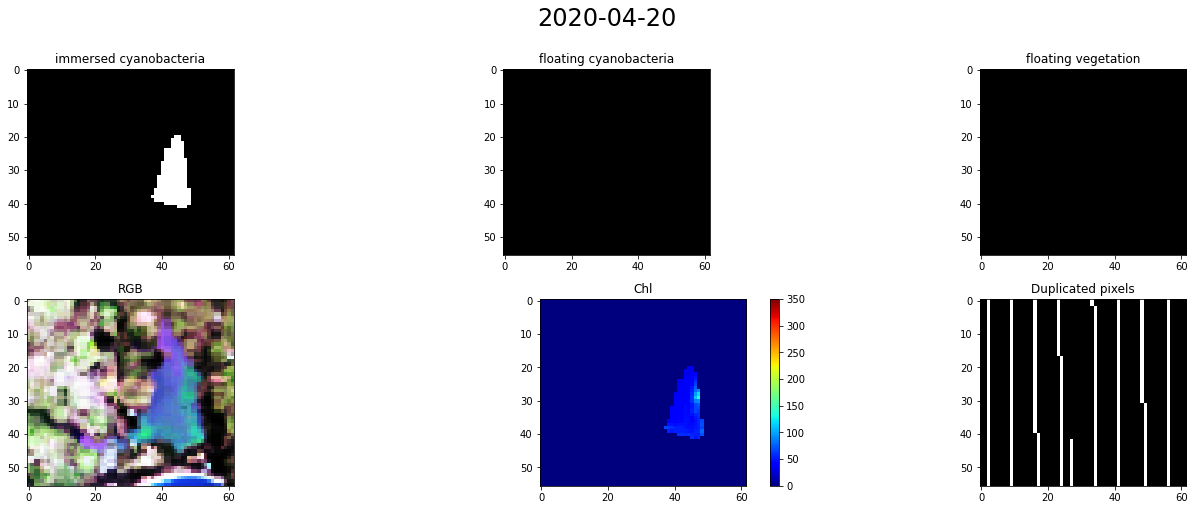

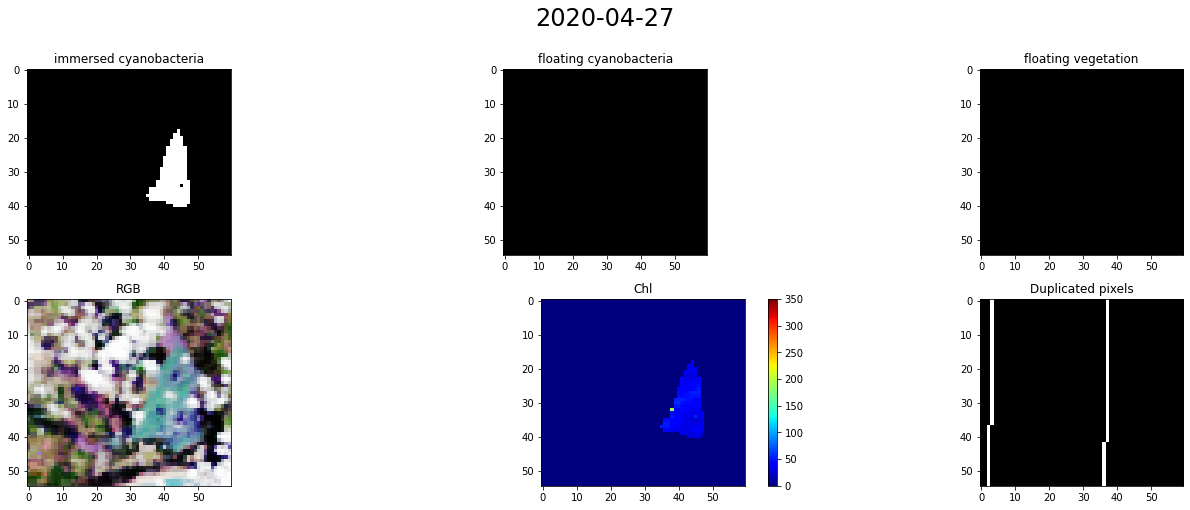

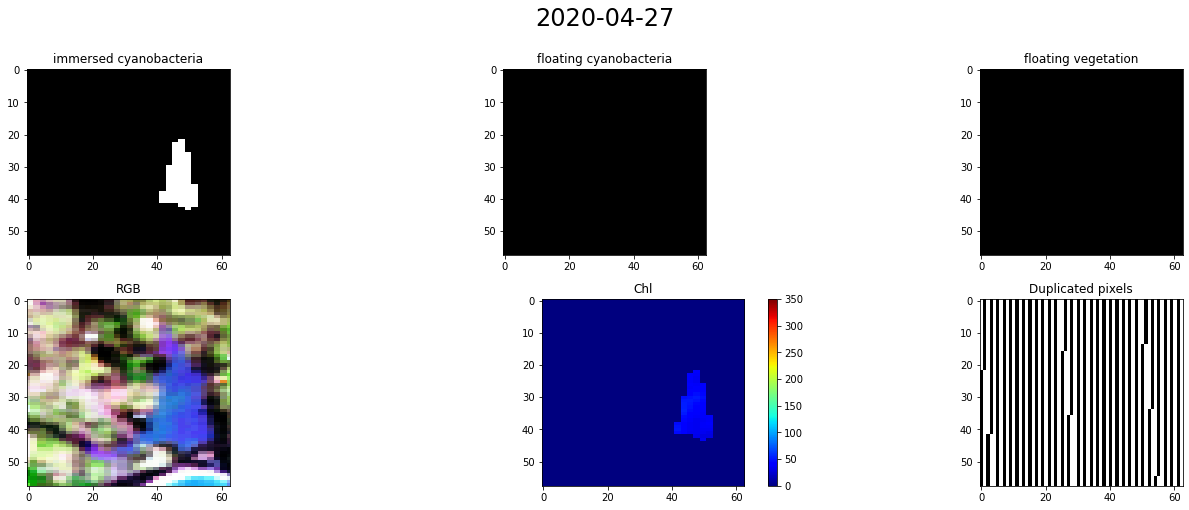

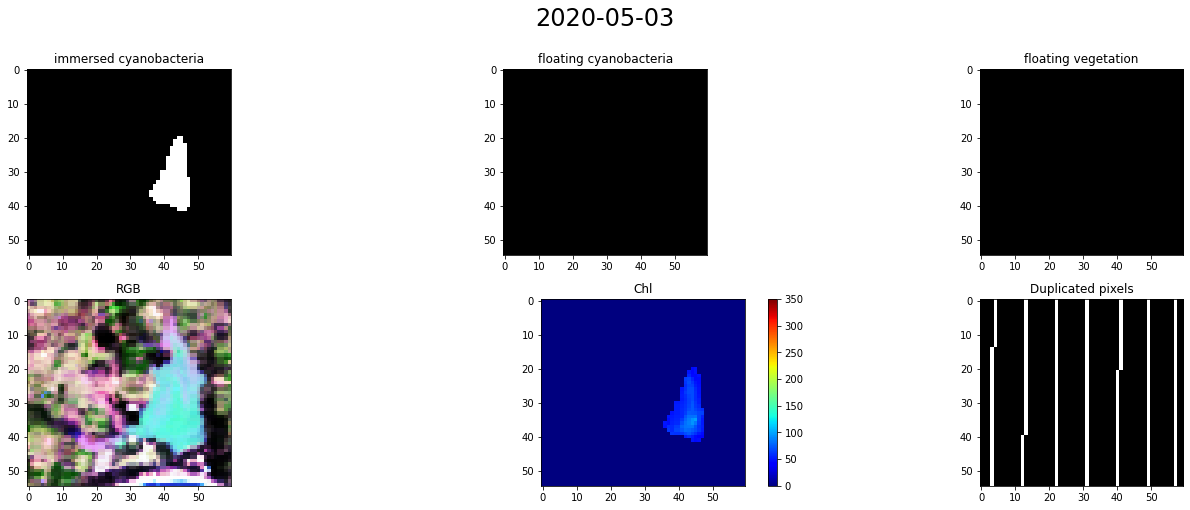

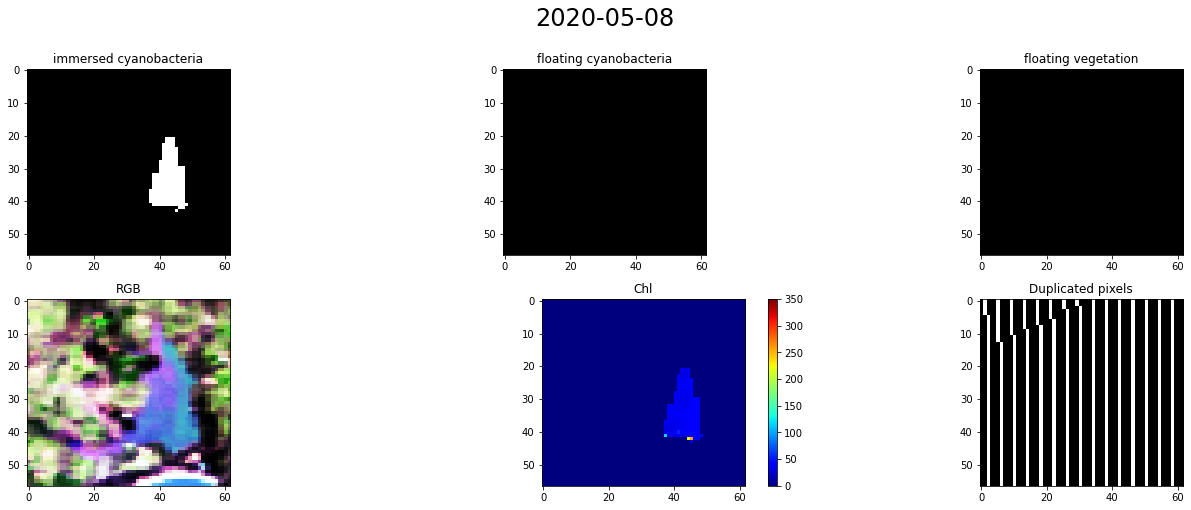

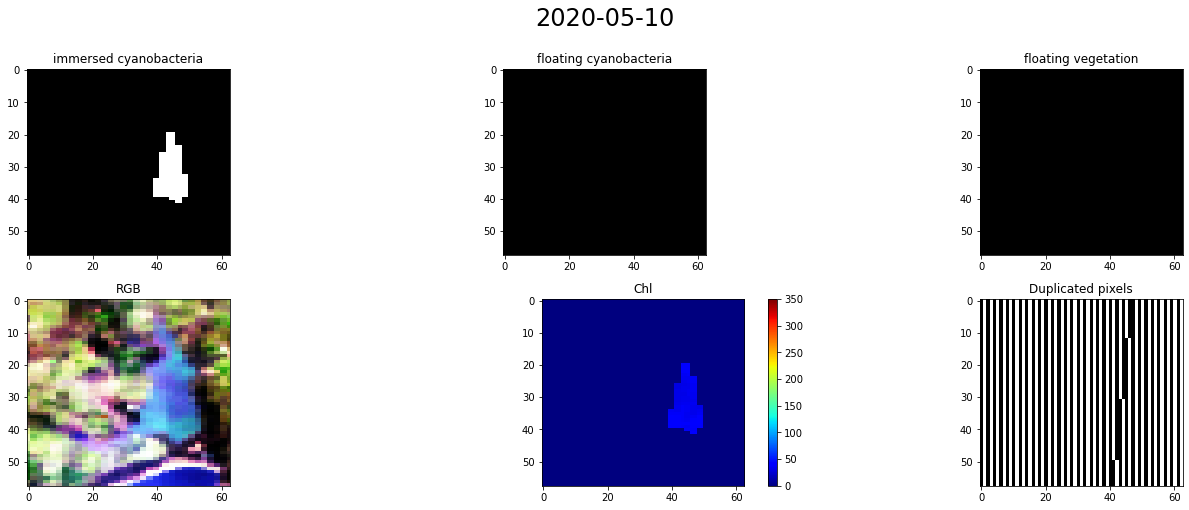

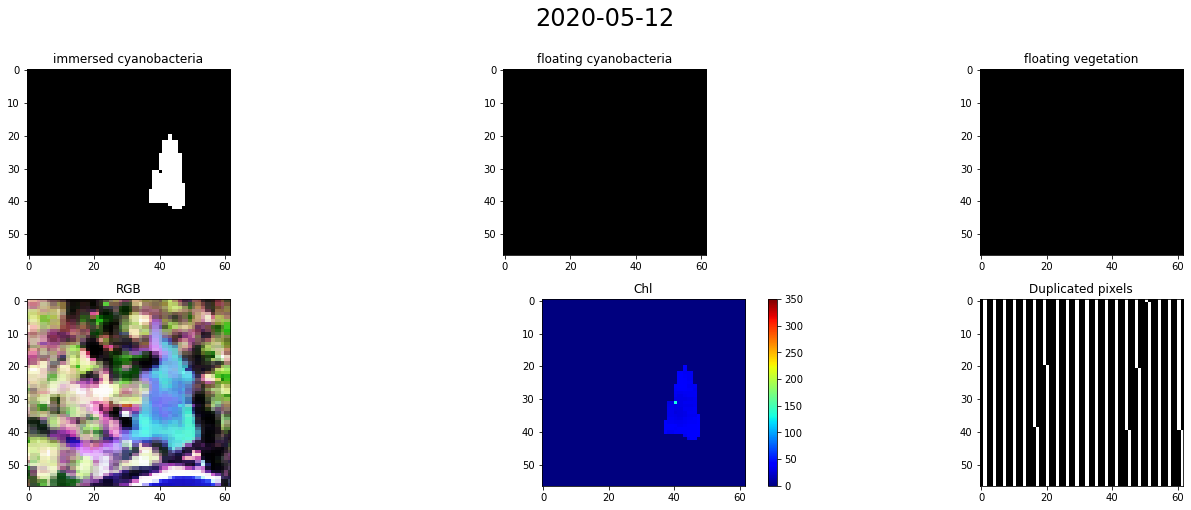

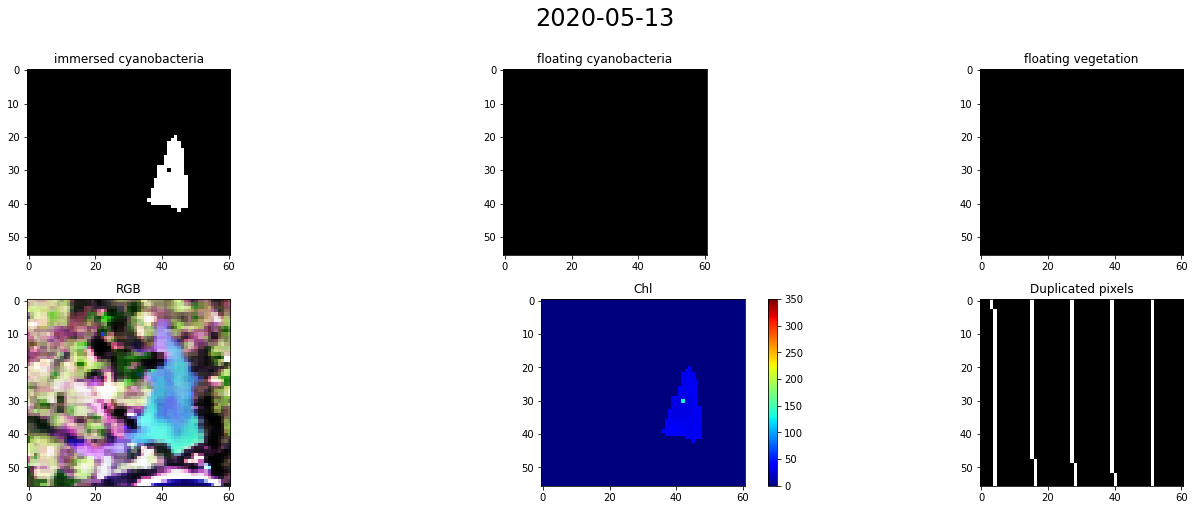

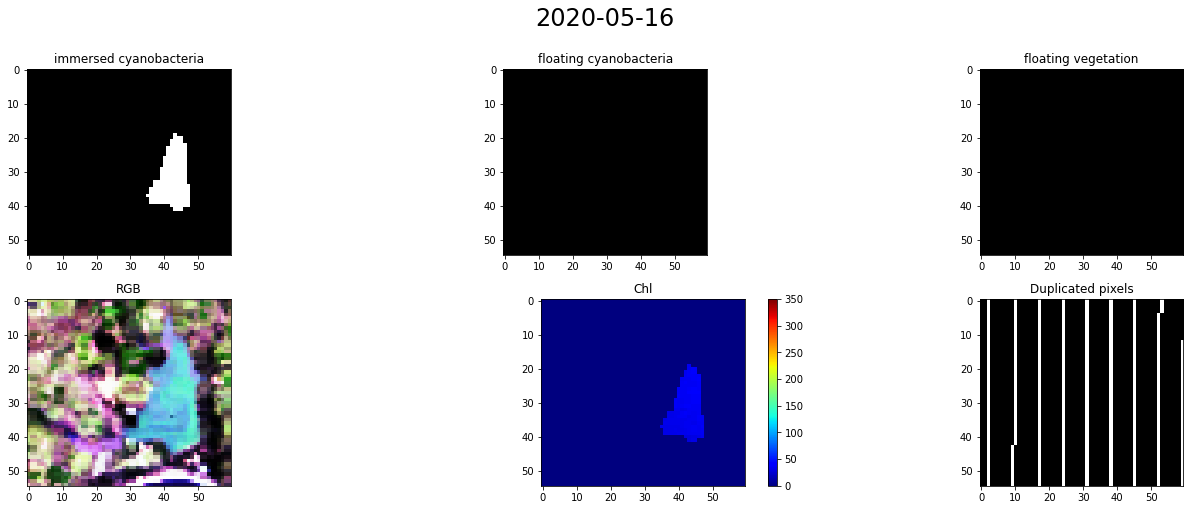

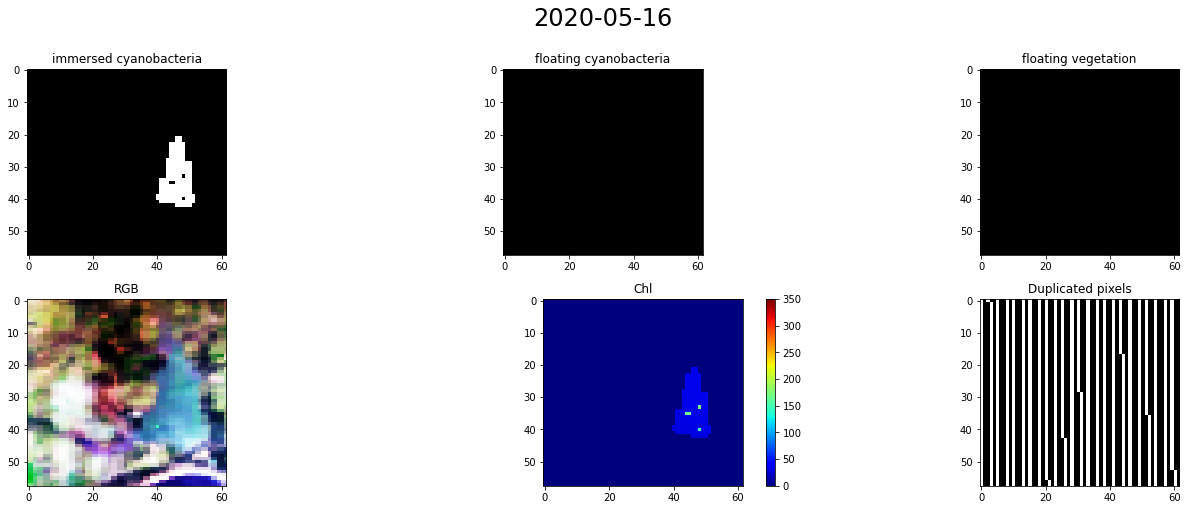

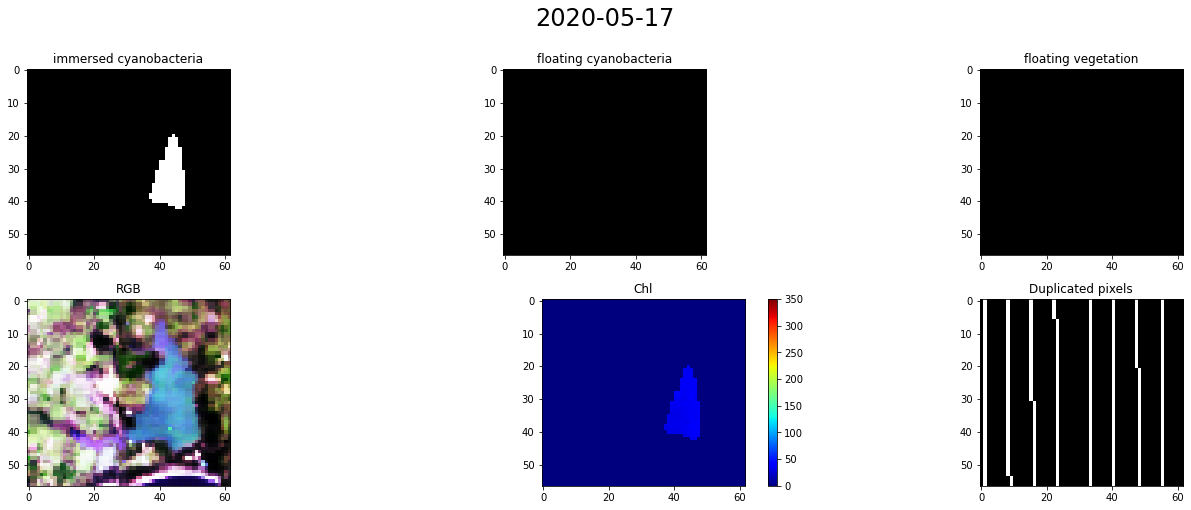

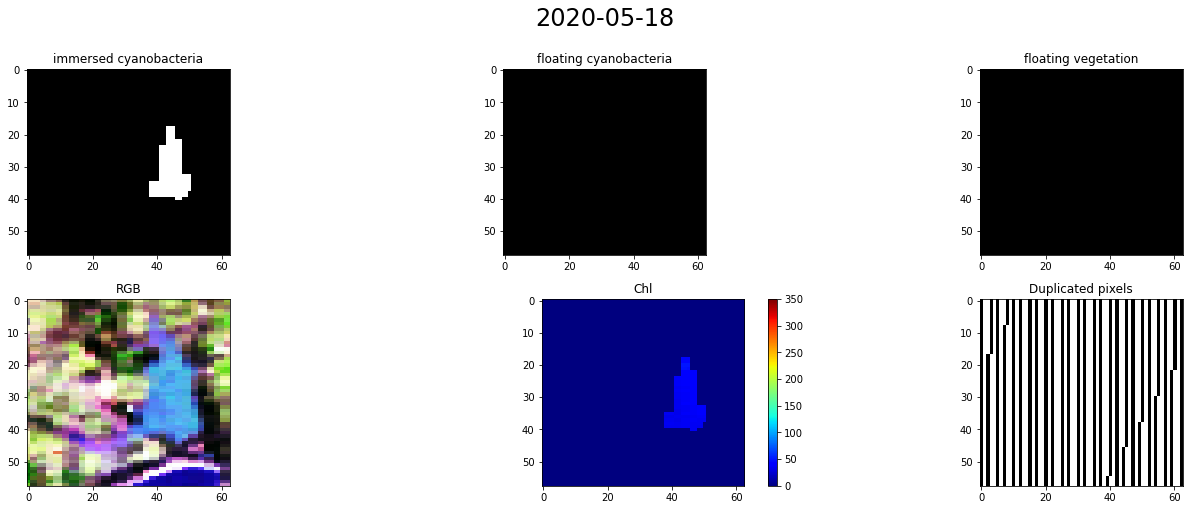

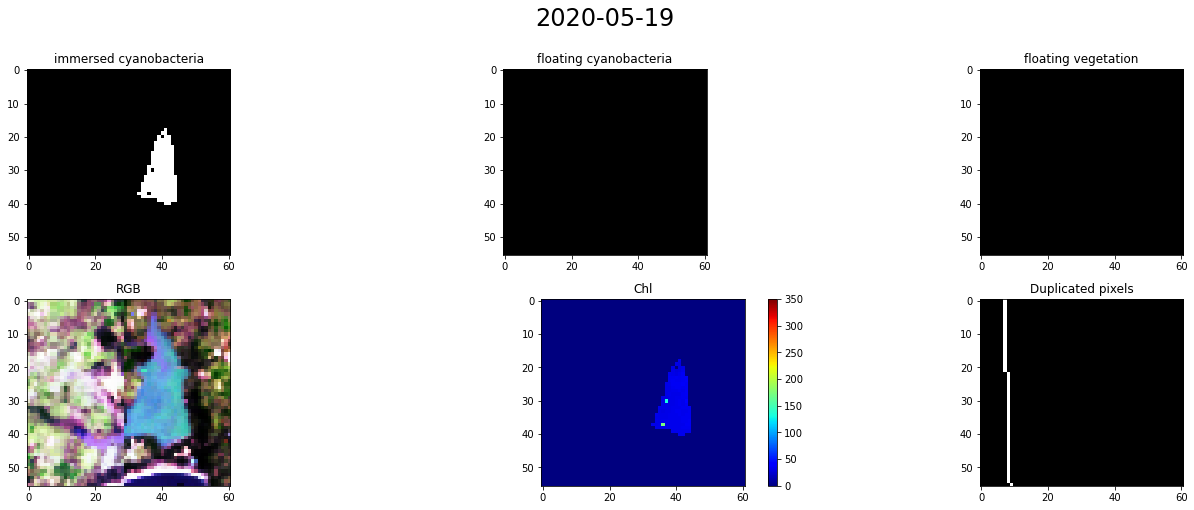

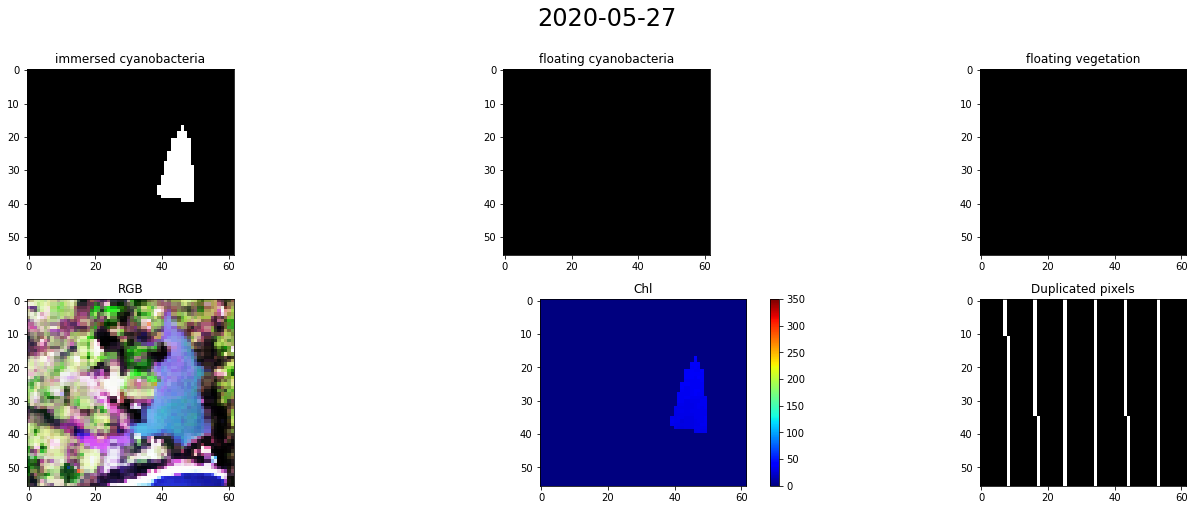

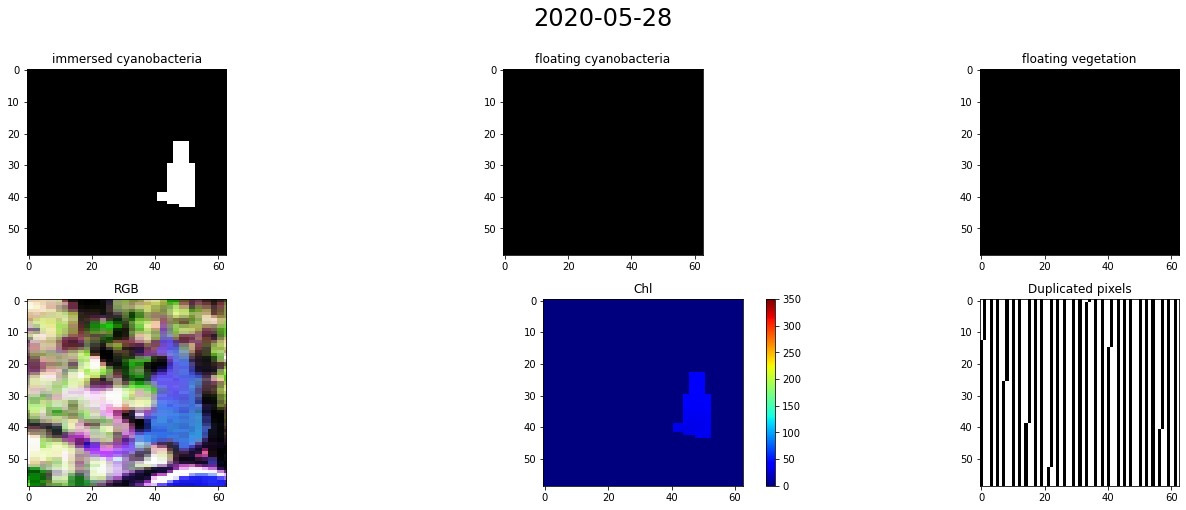

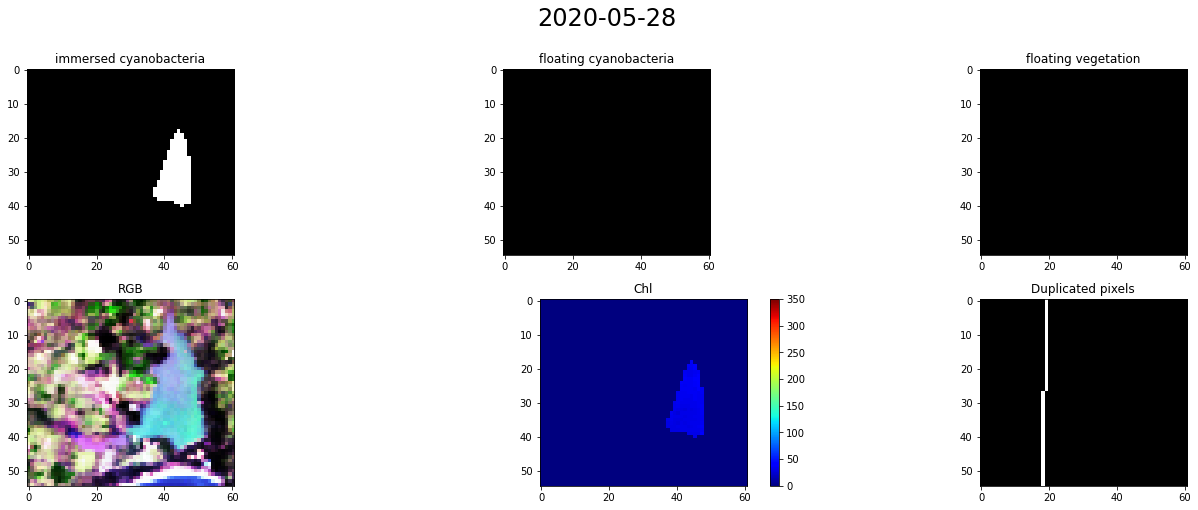

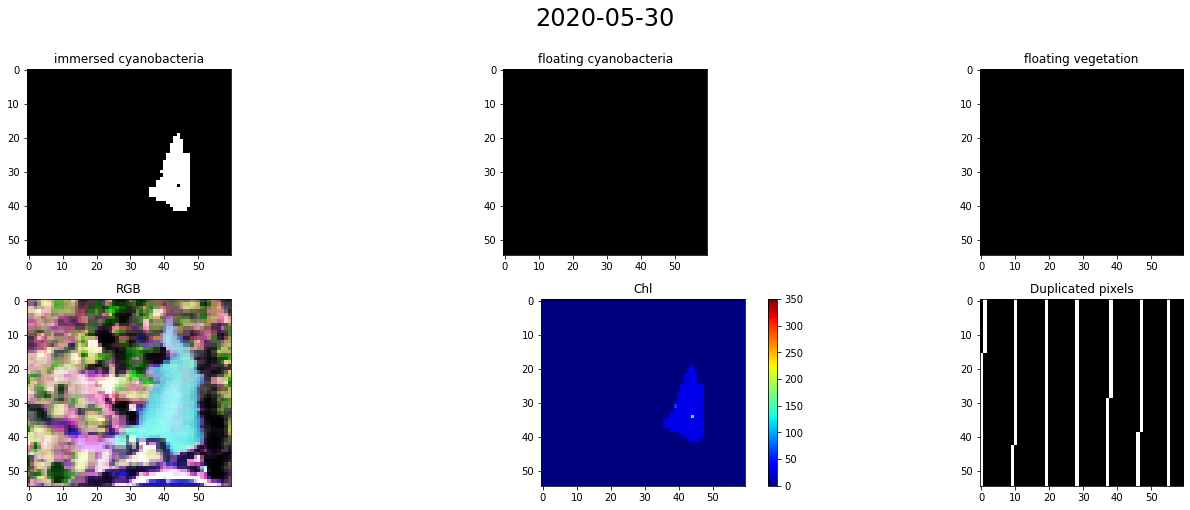

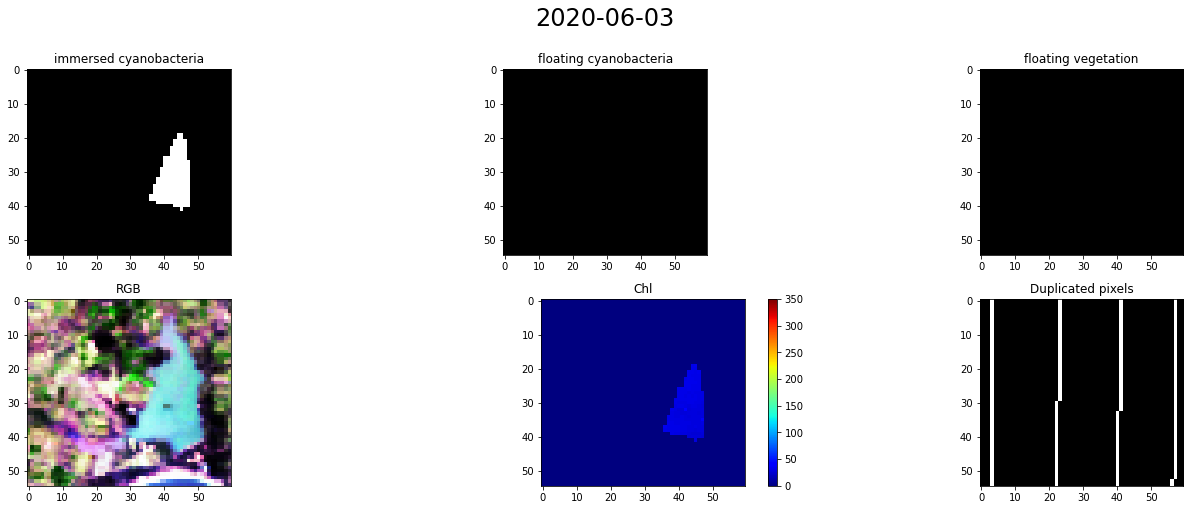

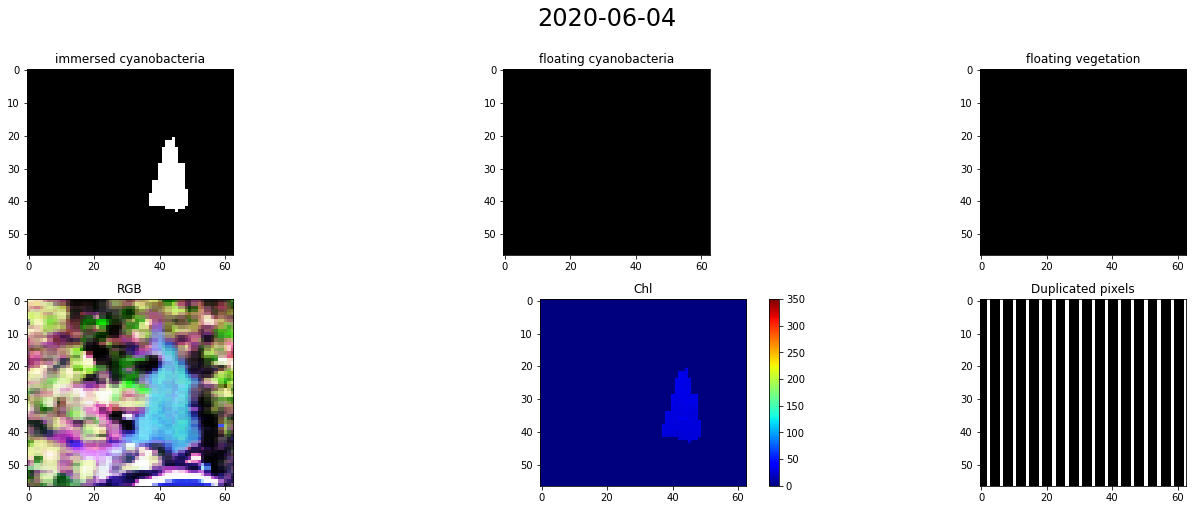

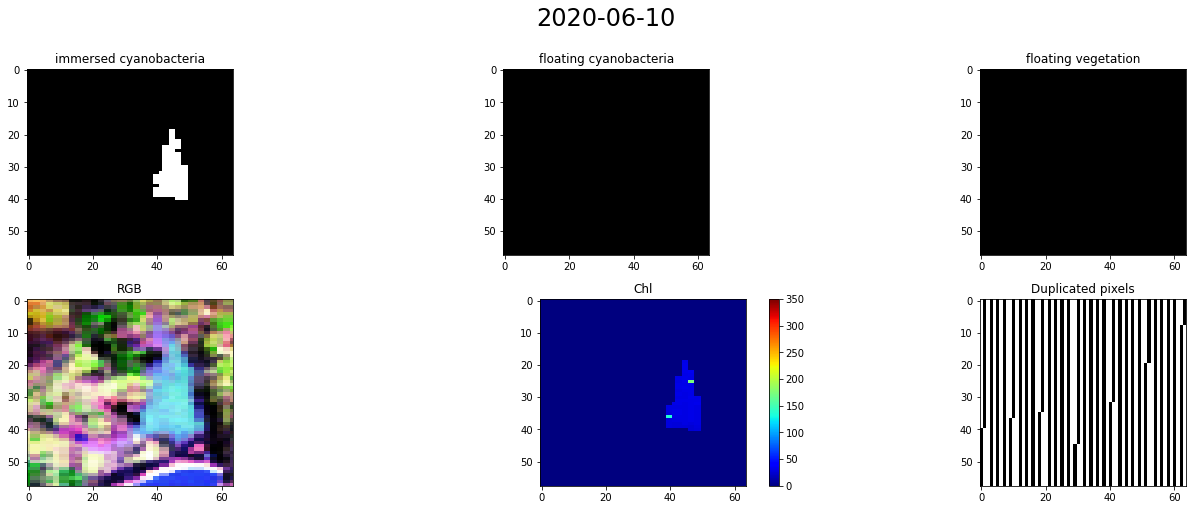

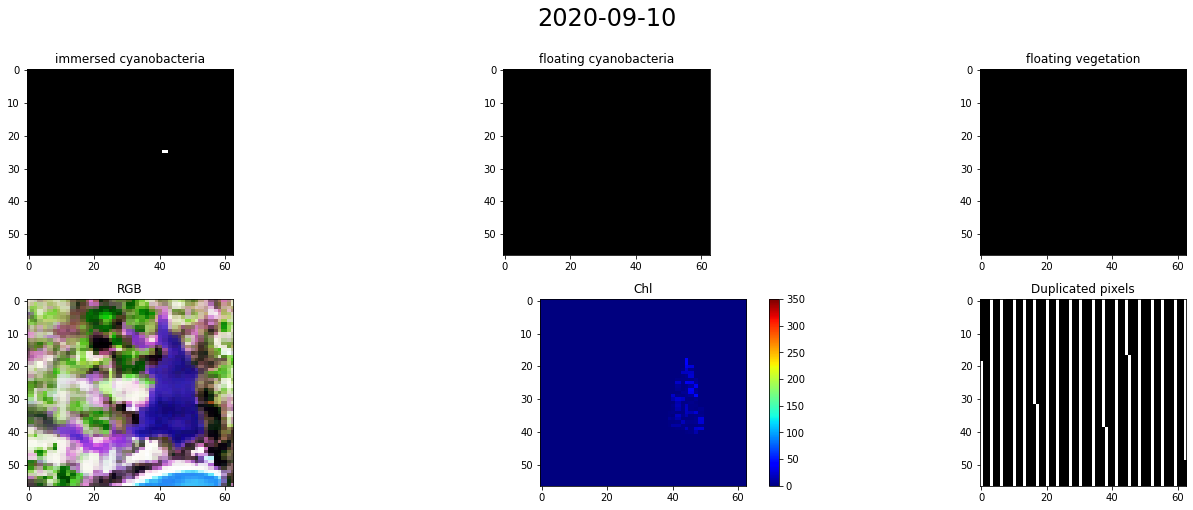

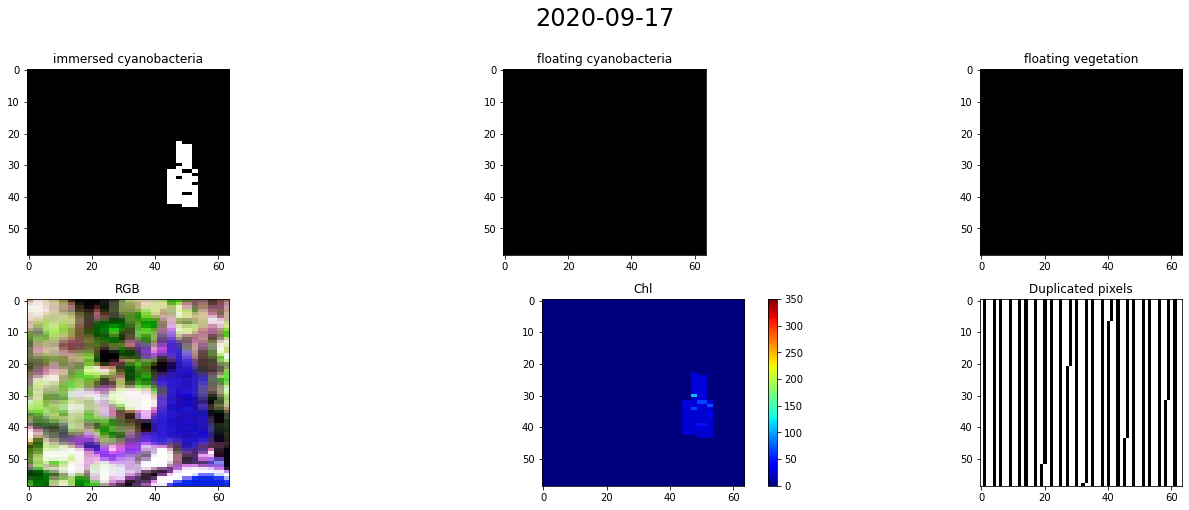

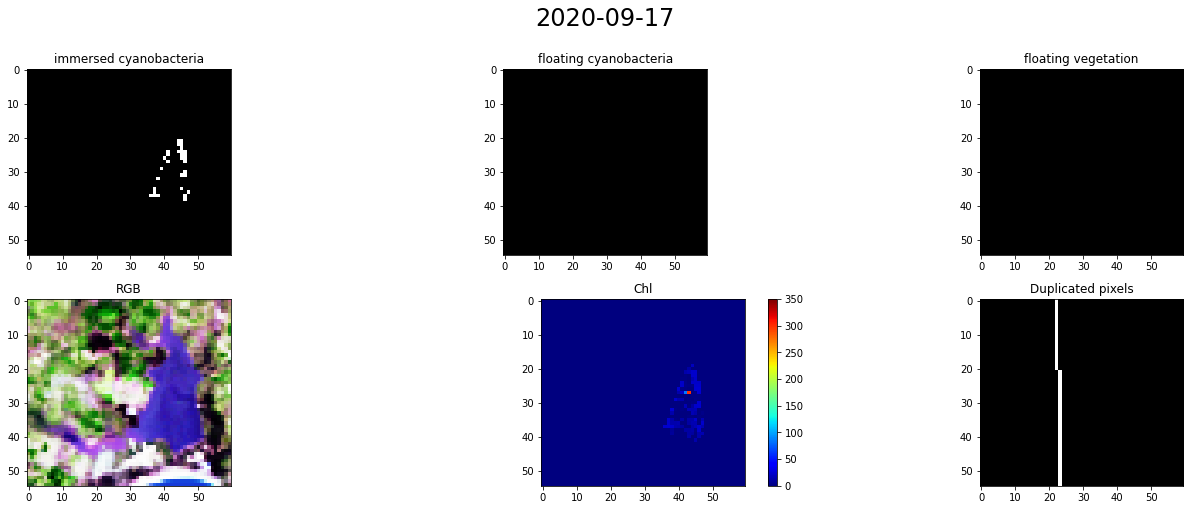

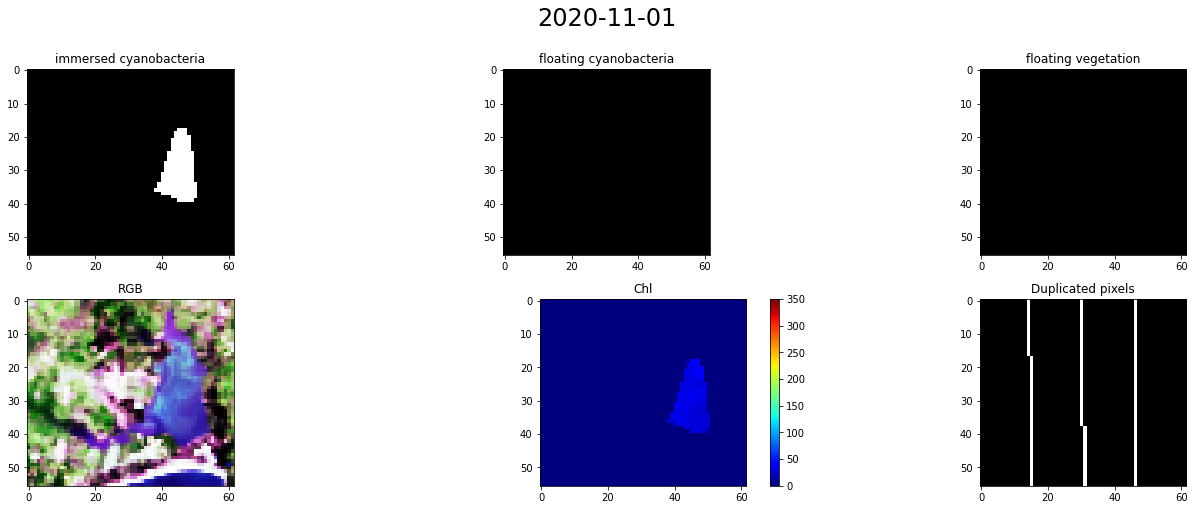

In [4]:
SAMPLE_COORDS = [CONTROL_COORDS[i] for i in [0, 8, 16]]
# data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=CYANO_GT_DAYS, skip_invalid=True,
#                                   mask_coordinates=SAMPLE_COORDS, mask_type="sparse")

data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=CYANO_GT_DAYS, skip_invalid=True,
                                  mask_coordinates=INTERNAL_CONTOUR_2)

for day in data_generator:
    fig2 = plt.figure(figsize=(20,10))
    
    fig2.add_subplot(331).title.set_text("immersed cyanobacteria")
    plt.imshow(day.mph.immersed_cyanobacteria*day.mask, cmap="gray")
    
    fig2.add_subplot(332).title.set_text("floating cyanobacteria")
    plt.imshow(day.mph.floating_cyanobacteria*day.mask, cmap="gray")
    
    fig2.add_subplot(333).title.set_text("floating vegetation")
    plt.imshow(day.mph.floating_vegetation*day.mask, cmap="gray")
    
    fig2.add_subplot(334).title.set_text("RGB")
    #day.paint_coords(CONTROL_COORDS, [255, 119, 255])
    plt.imshow(day.rgb)
    
    fig2.add_subplot(335).title.set_text("Chl")
    plt.imshow(day.mph.chl*day.mask, cmap='jet', interpolation='none',
              vmin=0, vmax=350)
    plt.colorbar()
    
    fig2.add_subplot(336).title.set_text("Duplicated pixels")
    plt.imshow(day.duplicated, cmap='gray')
    
    fig2.suptitle(str(day.date.date()), fontsize=24, y=1)
    fig2.tight_layout()
    
#     if str(day.date.date()) in processed_dates:
#         img_save_path = os.path.join("verano2020-2", str(day.date.date()) + "-2" + ".png")
#     else:
#         img_save_path = os.path.join("verano2020-2", str(day.date.date()) + ".png")
    
#     plt.savefig(img_save_path)    

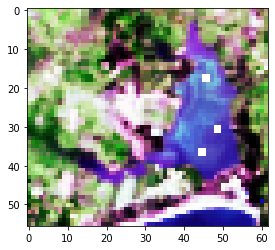

In [13]:
import cv2

sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.829670, -55.049758]}

day = OLCIdata("/home/ubuntu/cianobacterias/data/processed/2020-11-01/OLCI/subselection_0.dim")
day.create_sparse_mask([c for c in sampling_points_coords.values()])
img_with_mask = day.rgb.copy()
for i, row in enumerate(day.mask):
    for j, value in enumerate(row):
        if value == True:
            img_with_mask[i, j] = 255
plt.imshow(img_with_mask)